### Install and import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

In [2]:
# Import the psf rutines
import Degrade.psf_script as PSF

### Model
Input size: npca_m * 6 = 8*6 = 48 \
Output size: npca_s * 4 = 12 * 4 = 48

In [3]:
class Net(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(Net, self).__init__()
        
        self.act = nn.ELU(inplace=True)                # Activation function

        self.l1 = nn.Linear(inputSize, inputSize)
        self.l2 = nn.Linear(inputSize, 50)
        self.l3 = nn.Linear(50, 60)
        self.l4 = nn.Linear(60, 70)
        self.l5 = nn.Linear(70, 80)
        self.l6 = nn.Linear(80, 90)
        self.l7 = nn.Linear(90, 80)
        self.l8 = nn.Linear(80, 70)
        self.l9 = nn.Linear(70, 60)
        self.l10 = nn.Linear(60, 50)
        self.l11 = nn.Linear(50, outputSize)
        self.l12 = nn.Linear(outputSize, outputSize)

        
    def weights_init(self):
        #Initialize all weights
    
        for module in self.modules():
            kaiming_init(module)
            
    def forward(self, x):                                    
        for i in [self.l1, self.l2, self.l3, self.l4, self.l5, self.l6,
                    self.l7, self.l8, self.l9, self.l10, self.l11]:
            x = i(x)
            x = self.act(x)
            
        x = self.l12(x)

        return x


### Dataset
npca_s = 12 \
npca_m = 8

In [4]:
class Data(torch.utils.data.Dataset):

    def __init__(self, n_training=None, npca_m=8, npca_s=12, 
                 mags_file='models/ivan_models.fits', 
                 stokes_file='models/ivan_models_synth.fits'):
        
        
        # Read data cubes
        self.mags = fits.open(mags_file)[0].data
        self.mags[8,:,:] %= np.pi
        self.stokes = fits.open(stokes_file)[0].data
        
        # Delete mags columns 0,1,4,5,6
        self.mags = np.delete(self.mags, [0,1,4,5,6,8], axis=0)
        
        # Equal stokes NaN values to zero. These zeros will be deleted later.
        self.stokes[np.isnan(self.stokes)] = 0
        
        
        # Get the dimensions of the cubes
        n_mags, n1_m, n2_m, n3_m = self.mags.shape
        n1_s, n2_s, n_stokes, n_lambda = self.stokes.shape
        self.stokes = np.transpose(self.stokes, axes=(2,0,1,3))
        
        
        # Convolution between PSF and stokes cube, for every parameter and wavelenght
        self.conv_stokes = np.empty(self.stokes.shape)
        for i in np.arange(n_stokes):
            for j in np.arange(n_lambda):
                self.conv_stokes[i,:,:,j] = PSF.osys.convolve_with_psf(self.stokes[i,:,:,j])      
        
        
        # Just a copy to plot the new 288x288 image later
        self.conv_stokes_0 = self.conv_stokes

        
        # Dimension reduction
        self.mags = self.mags.reshape((n_mags, n1_m*n2_m, n3_m))
        self.stokes = self.stokes.reshape((n_stokes, n1_s*n2_s, n_lambda))
        self.conv_stokes = self.conv_stokes.reshape((n_stokes, n1_s*n2_s, n_lambda))
        
        

        # There are some profiles with NaN. Remove them
        tmp = np.sum(self.mags, axis=(0,2))
        ind = np.where(np.isnan(tmp) == True)[0]
        self.mags = np.delete(self.mags, ind, axis=1)

        # Indexes where we equalized NaN to 0 before
        tmp = np.sum(self.stokes, axis=(0,2))
        ind = np.where(tmp==0)[0]          
        # Delete those indexes from the convolved stokes cube
        self.conv_stokes= np.delete(self.conv_stokes, ind, axis=1)
        
        
        
        # Train with all the 288x288 values or with a subset
        self.n_values = self.conv_stokes.shape[1]
        if (n_training is None):            
            self.n_training = self.n_values
        else:
            self.n_training = n_training
        

        self.npca_s = npca_s
        self.npca_m = npca_m
            
        self.cov_m, self.U_m, self.W_m, self.V_m, self.coeff_m = self.PCA(self.mags)
        self.cov_s, self.U_s, self.W_s, self.V_s, self.coeff_s = self.PCA(self.conv_stokes)
        
        
        # Stokes multiplier
        self.multiplier_cs = np.array([3e27, 1e25, 1e25, 3e25])

        # Magnitudes multiplier
        self.multiplier_cm = np.array([5e4,8e5,2e4,1e7,5e1,10])
        
    def PCA(self,data):
        d1,d2,d3 = data.shape
        # Create PCA related arrays
        cov = np.empty((d1, d3, d3))
        U = np.empty((d1, d3, d3))
        W = np.empty((d1, d3, d3))
        V = np.empty((d1, d3, d3))
        coeff = np.zeros((d1, d2, d3))
            
        # Calculate the values
        for i in np.arange(d1):
            cov[i,:,:] = data[i,:,:].T @ data[i,:,:]
            U[i,:,:], W[i,:,:], V[i,:,:]  = np.linalg.svd(cov[i,:,:])
            coeff[i,:,:] = data[i,:,:] @ V[i,:,:].T
            
        return cov, U, W, V, coeff
                                      
    def __getitem__(self, index):
        out_stokes = self.coeff_s[:, index, 0:self.npca_s] / self.multiplier_cs[:, None]
        out_mags = self.coeff_m[:, index, 0:self.npca_m] / self.multiplier_cm[:, None]
        
        return out_mags.flatten().astype('float32'), out_stokes.flatten().astype('float32')
            
     
    def __len__(self):
        return self.n_training

### Map vectors

In [17]:
c=0

In [18]:
class Map(object):
    
    def __init__(self, checkpoint, batch_size=2*2560, lr=3e-4,
                        validation_split=0.2, n_epochs=1000,
                        gpu=0, num_workers=0,
                        inputSize = 6 * Data().npca_m,
                        outputSize = 4 * Data().npca_s):

        global c
        c += 1
        
        self.validation_split=validation_split
        self.n_epochs=n_epochs
        self.batch_size = batch_size
        
        # Check if a GPU is available
        self.cuda = torch.cuda.is_available()
        self.gpu = gpu        

        # In case there is, select it. Otherwise, default to CPU
        self.device = torch.device(f"cuda:{self.gpu}" if self.cuda else "cpu")
        
        # Use  num_workers to provide data to the GPU
        self.kwargs = {'num_workers': num_workers, 'pin_memory': False} if self.cuda else {}
        
        
        # Dataset and model
        self.dataset =  Data(n_training=None)
        self.npca_s = self.dataset.npca_s
        self.npca_m = self.dataset.npca_m
        self.net = Net(inputSize, outputSize).to(self.device)
        

        # Create a stochastic gradient descent optimizer
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

        
        # Create a loss function (mean absolute error)
        self.criterion = nn.MSELoss()
        
        
        if checkpoint:
            checkpoint = torch.load("checkpoint/checkpoint{}.pt".format(str(c-1)))
            self.net.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
        else: 
            self.net.weights_init()

        
        # Compute the fraction of data for training/validation
        idx = np.arange(self.dataset.n_training)
        self.train_index = idx[0:int((1-validation_split)*self.dataset.n_training)]
        self.validation_index = idx[int((1-validation_split)*self.dataset.n_training):]
            
        # Define samplers for the training and validation sets
        self.train_sampler = torch.utils.data.sampler.SubsetRandomSampler(self.train_index)
        self.validation_sampler = torch.utils.data.sampler.SubsetRandomSampler(self.validation_index)
        
        # Data loaders that will inject data during training
        self.validation_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, 
                                                                sampler = self.validation_sampler, 
                                                                shuffle=False, **self.kwargs)
        self.train_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, 
                                                        sampler=self.train_sampler, 
                                                        shuffle=False, **self.kwargs)
         

    def save_ckp(self, state, is_best, checkpoint_dir, best_model_dir):
        f_path = '{}/checkpoint_def{}.pt'.format(checkpoint_dir, str(c))
        torch.save(state, f_path)
        if is_best:
            best_fpath = '{}/checkpoint.pt'.format(best_model_dir)
            shutil.copyfile(f_path, best_fpath)
    
    
    def train(self):
        
        # Put the model in training mode (weights will be modified)
        self.net.train()
        self.loss_train = []
        self.batch_train = []
        #t = tqdm(self.train_loader)
        
        for batch_idx, data in enumerate(self.train_loader):

            # get the inputs
            mags, stokes = data[0].to(self.device), data[1].to(self.device)

            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            net_out = self.net(mags)
            loss = self.criterion(net_out, stokes)
            loss.backward()
            self.optimizer.step()
            
            self.batch_train.append(batch_idx)
            self.loss_train.append(loss.item())

        
    def test(self):
        
        # Put the model in evaluation mode
        self.net.eval()
        self.loss_val = []
        self.batch_val = []
        #t = tqdm(self.validation_loader)

        with torch.no_grad():
            for batch_idx, data in enumerate(self.validation_loader):
        
                mags, self.stokes_val = data[0].to(self.device), data[1].to(self.device)

                self.net_out = self.net(mags)
                loss = self.criterion(self.net_out, self.stokes_val)
                
                self.batch_val.append(batch_idx)
                self.loss_val.append(loss.item())
                

    # Reconstruction function, form coefficients dim=(1,4,npca) to a Stokes vector dim=(1,4,601)
    # using V dim=(601,4,601)
    # It reverses normalization too
    def recon_x(self,x):
        recon = np.zeros((4,1,601))
        for i in np.arange(4):
            recon[i,:,:]= np.einsum('ij, jk -> ik', x[i, :, 0:self.npca_s].cpu() * self.dataset.multiplier_cs[i], 
                                    self.dataset.V_s[i,0:self.npca_s, :])
        return recon.reshape((4,601))
        
    
    
    """
    def coef_error(self):
        
        self.optimize()
        n_vectors = len(self.net_out/(4*self.npca_s))
        stokes_out = self.net_out.reshape((n_vectors,4,self.npca_s))
        stokes_val = self.stokes_val.reshape((n_vectors,4,self.npca_s))
        abs_error = abs( (stokes_out - stokes_val) / stokes_val )
        plt.figure(figsize=(60,30))
        
        
        for j, letter in enumerate(['I','Q','U','V']):
            plt.subplot(2,2,j+1)
            mean = np.zeros(13)
            for i in range(13):
                mean[i] = np.mean(abs_error[:,j,i].cpu().numpy())
                
            plt.plot(range(self.npca_s), mean)
            plt.grid()
            plt.xticks(size=30), plt.yticks(size=30)
            plt.xlabel('Coeff index', fontsize=40)
            plt.ylabel('Absolute error', fontsize=40)
            plt.legend((letter), fontsize=40)
        plt.show()
        
        
        for index in np.array([0,6,12]):
            print('Index {}'.format(index+1))
            plt.figure(figsize=(60,30))
            for j, letter in enumerate(['I','Q','U','V']):
                plt.subplot(2,2,j+1)
                plt.plot(range(n_vectors), stokes_out[:,j,index].cpu().numpy())
                plt.plot(range(n_vectors), stokes_val[:,j,index].cpu().numpy())
                plt.legend(('net out', 'validation'),fontsize=40)
                plt.grid()
                plt.xticks(size=30), plt.yticks(size=30)
                plt.xlabel('last batch data indexes', fontsize=40)
                plt.ylabel('Value', fontsize=40)
                plt.title(letter, fontsize=40)
            plt.show()
    """

 

            
    # Train, test and then plot
    def optimize(self):
        self.loss_train_b = []
        self.loss_val_b = []
        self.loss_train_e = []
        self.loss_val_e = []
        
        # loop over the dataset multiple times     
        for epoch in range(self.n_epochs):
            """
            
            if epoch%50==0:
                print('Epoch %d' % (epoch+1))
            """    
            #print('Training...')
            self.train()
            #print('Testing...')
            self.test()
                    
            self.loss_train_b.extend(self.loss_train)
            self.loss_val_b.extend(self.loss_val)
            self.loss_train_e.append(np.mean(self.loss_train))
            self.loss_val_e.append(np.mean(self.loss_val))
            
            if self.loss_val_e[-1] < 0.00048:
                break
        
        checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': self.net.state_dict(),
                        'optimizer': self.optimizer.state_dict(),
                        'loss': self.loss_train_e,
                        'validation loss': self.loss_val_e,
                        'batch loss': self.loss_train_b,
                        'batch validation loss': self.loss_val_b,
                        'net out': self.net_out, 'stokes val': self.stokes_val,
                        'epochs': self.n_epochs}
        
        self.save_ckp(checkpoint, False, 'checkpoint', 'checkpoint/best')
        

    # Time to plot!
    def plotting(self):
        self.optimize()
        
        
        _ = plt.figure(figsize=(25,10))

        plt.subplot(211)
        plt.grid()
        plt.xticks(size=15), plt.yticks(size=15)
        plt.xlabel('epoch',fontsize=25), plt.ylabel('loss', fontsize=25)
        plt.plot(np.arange(len(self.loss_train_e)), self.loss_train_e)
        plt.plot(np.arange(len(self.loss_val_e)), self.loss_val_e,"r")
        plt.legend(('train loss', 'validation loss'),prop={'size': 23})
        

        plt.subplot(212)
        plt.grid()
        n=100
        plt.title('Last 100 epochs', fontsize=25)
        plt.xticks(size=15), plt.yticks(size=15)
        plt.xlabel('epoch',fontsize=25), plt.ylabel('loss', fontsize=25)
        plt.plot(np.arange(n), self.loss_train_e[-n:])
        plt.plot(np.arange(n), self.loss_val_e[-n:],"r")
        plt.legend(('train loss', 'validation loss'),prop={'size': 23})
        plt.tight_layout()
        plt.show()

        index_list = np.random.randint(0,(self.net_out.shape[0])+1,10)
        
        for i in index_list:
            stokes_out = self.net_out[i,:].reshape((4,1,self.npca_s))
            stokes_val = self.stokes_val[i,:].reshape((4,1,self.npca_s))
            recon_stokes_out = self.recon_x(stokes_out)
            recon_stokes_val = self.recon_x(stokes_val)
            
            print('')
            print( 'Last epoch, last batch. Index: {}'.format( i ) )
            _ = plt.figure(figsize=(30,20))
            
            for index, letter in enumerate(['I','Q','U','V']):
                ax = plt.subplot(2,2,index+1)
                ax.grid()
                ax.tick_params(axis='both', which='major', labelsize=15)
                ax.set_title(letter, fontsize=25)
                ax.plot(range(len(recon_stokes_out[index,:])), recon_stokes_out[index,:])
                ax.plot(range(len(recon_stokes_val[index,:])), recon_stokes_val[index,:], "r-", lw=2)
            
            plt.show()
            
        

### Test

Plot loss per batch and per epoch. \
From the last epoch and last test batch, plot 10 different original and predicted stokes vectors.

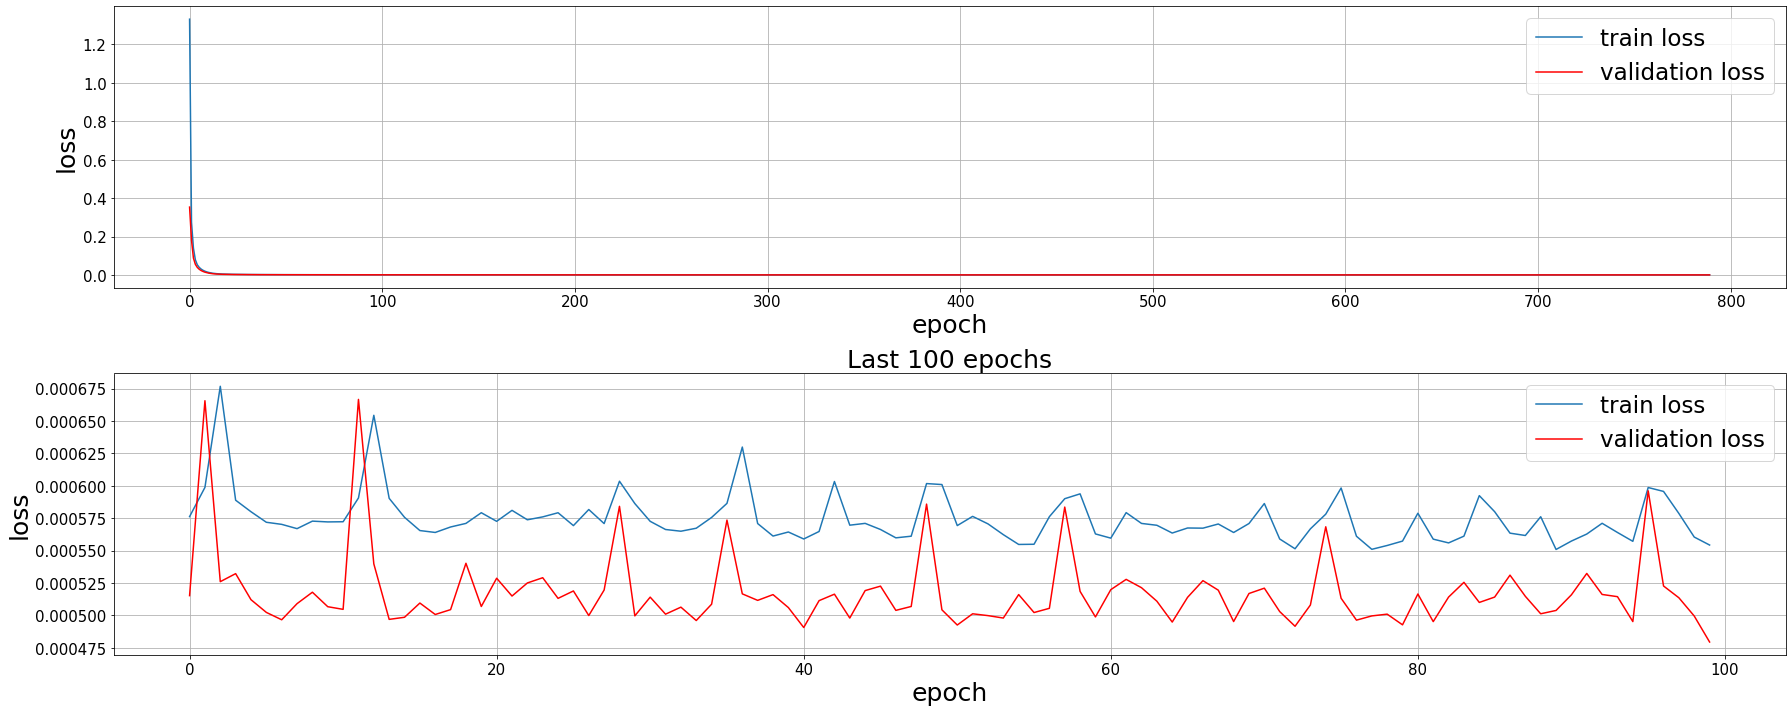


Last epoch, last batch. Index: 932


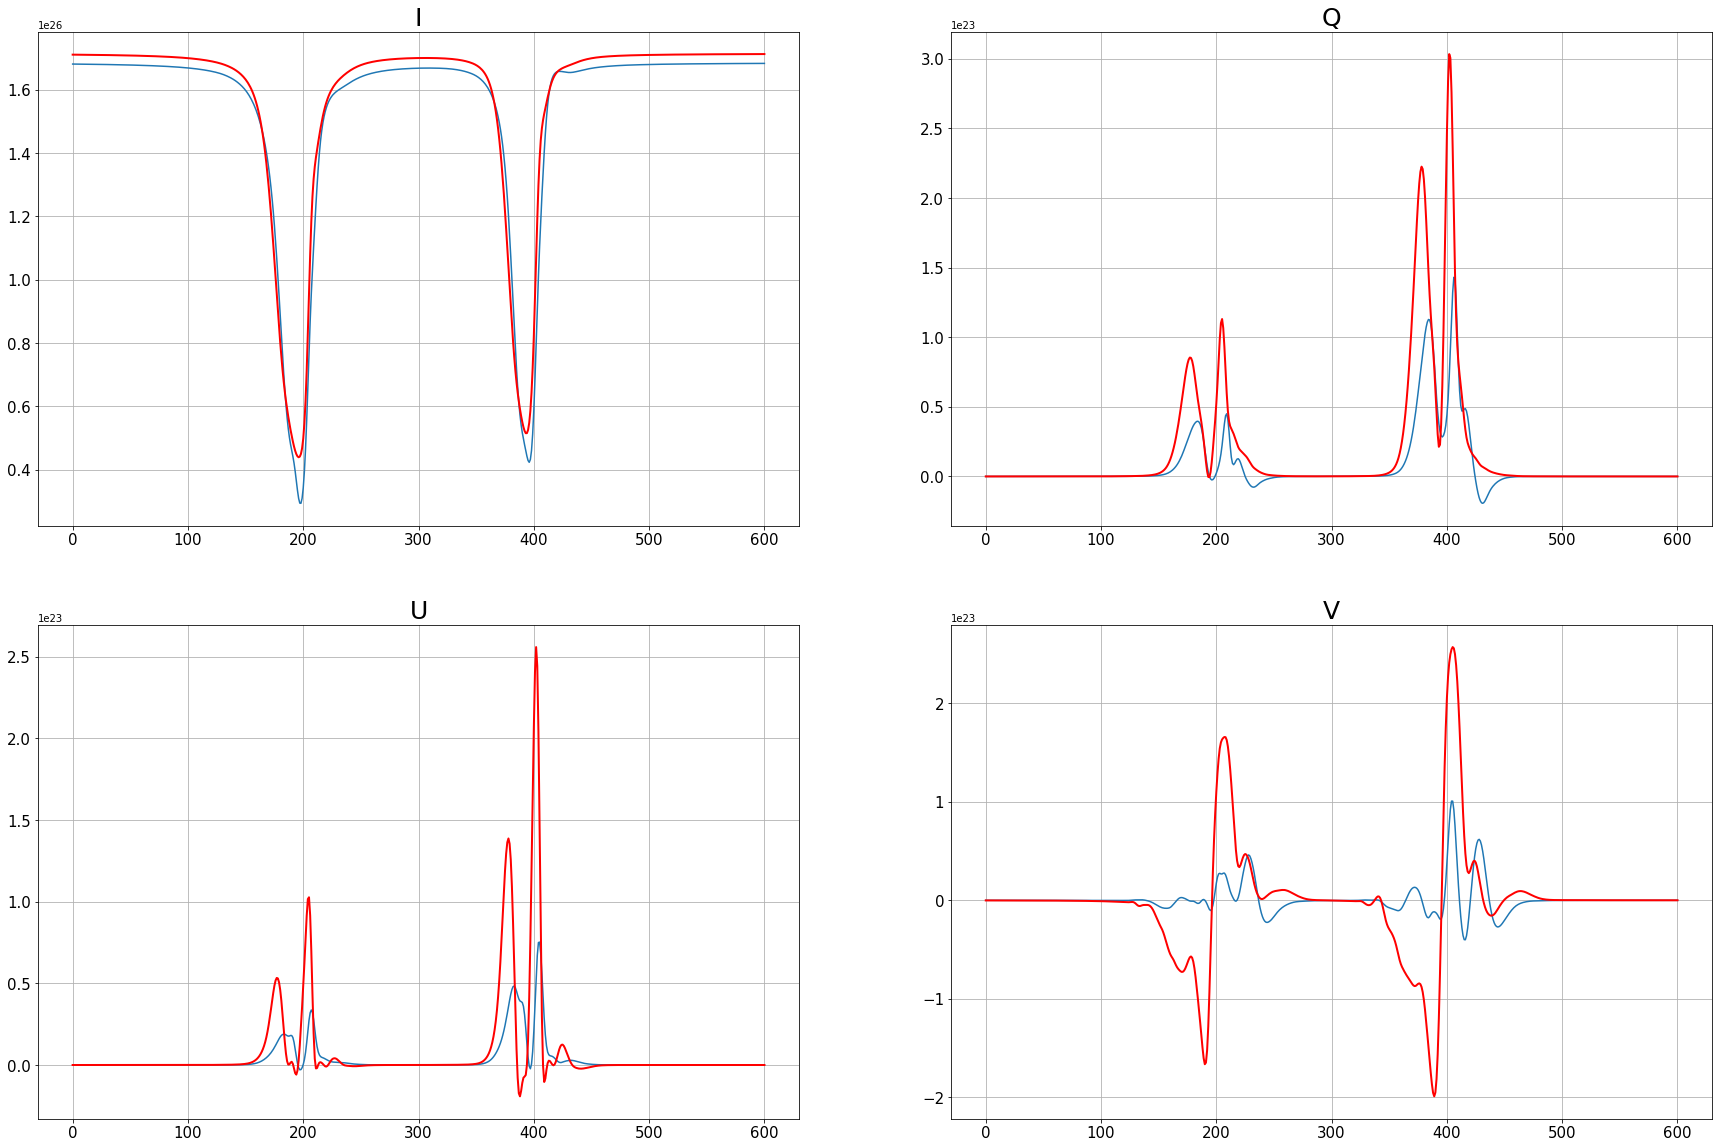


Last epoch, last batch. Index: 76


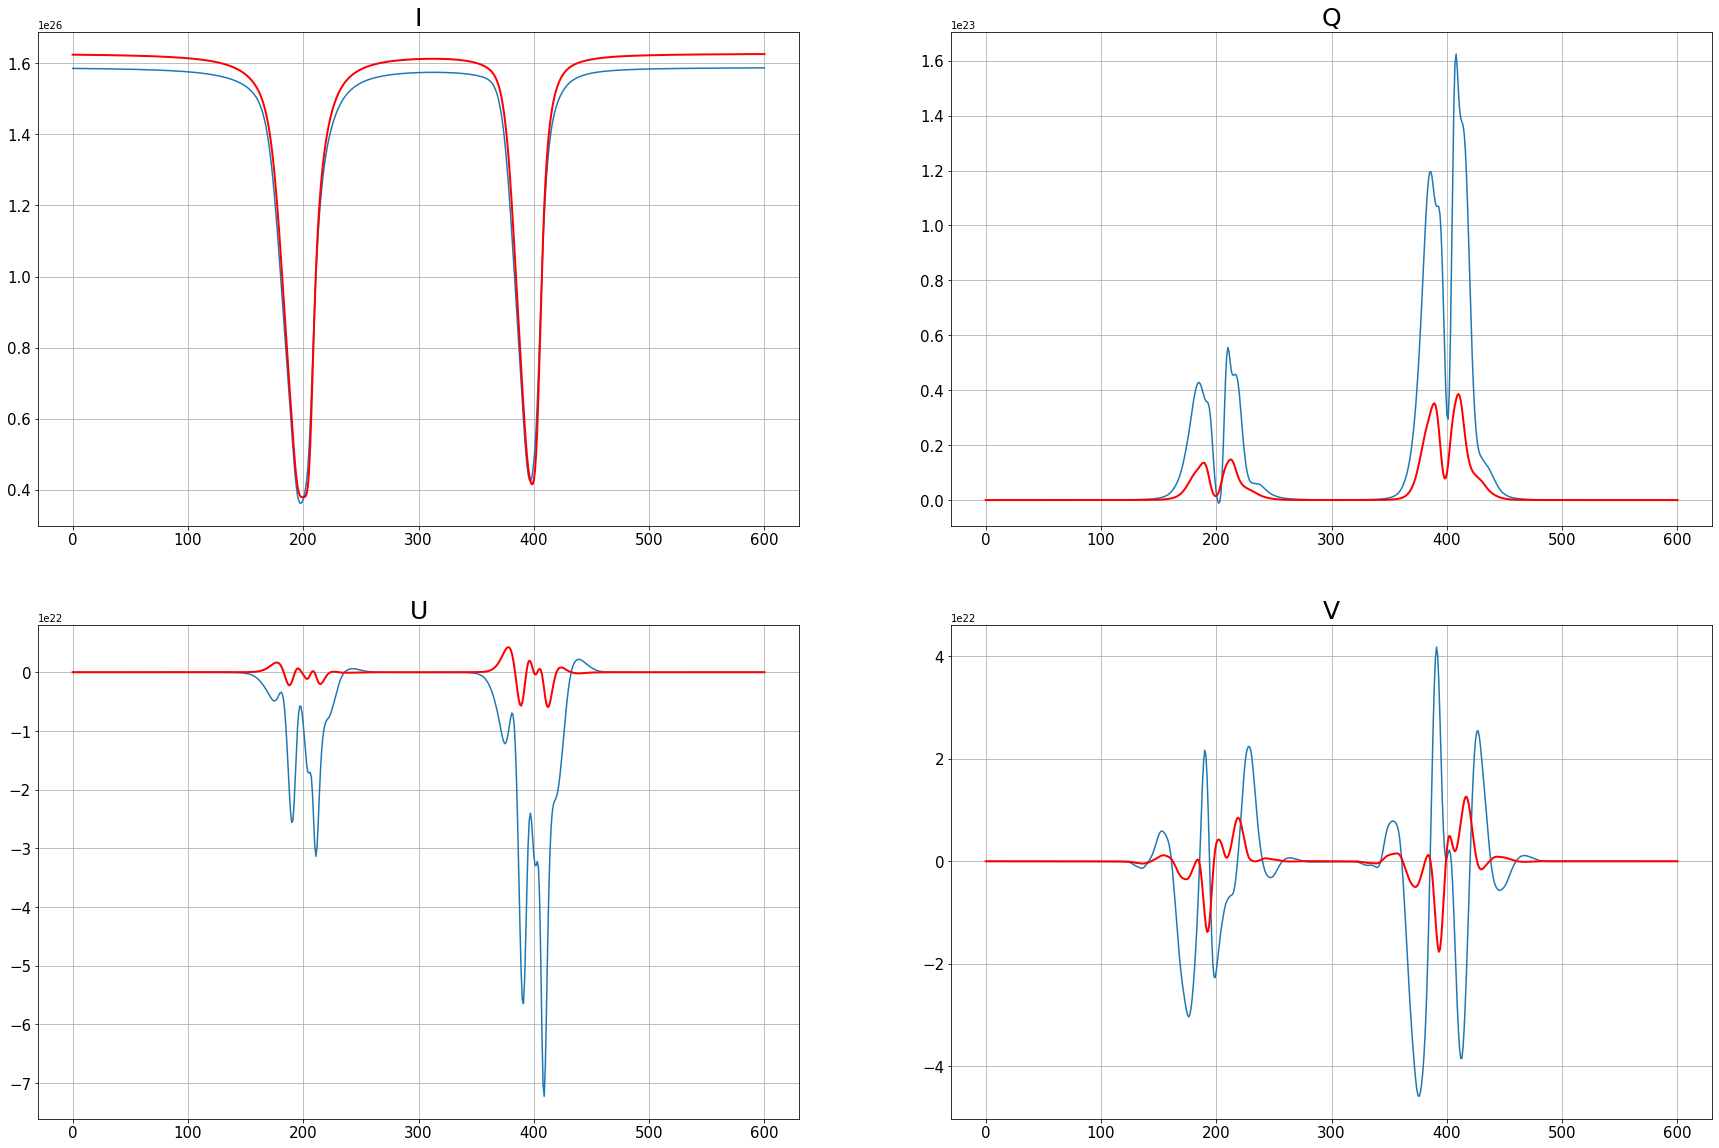


Last epoch, last batch. Index: 18


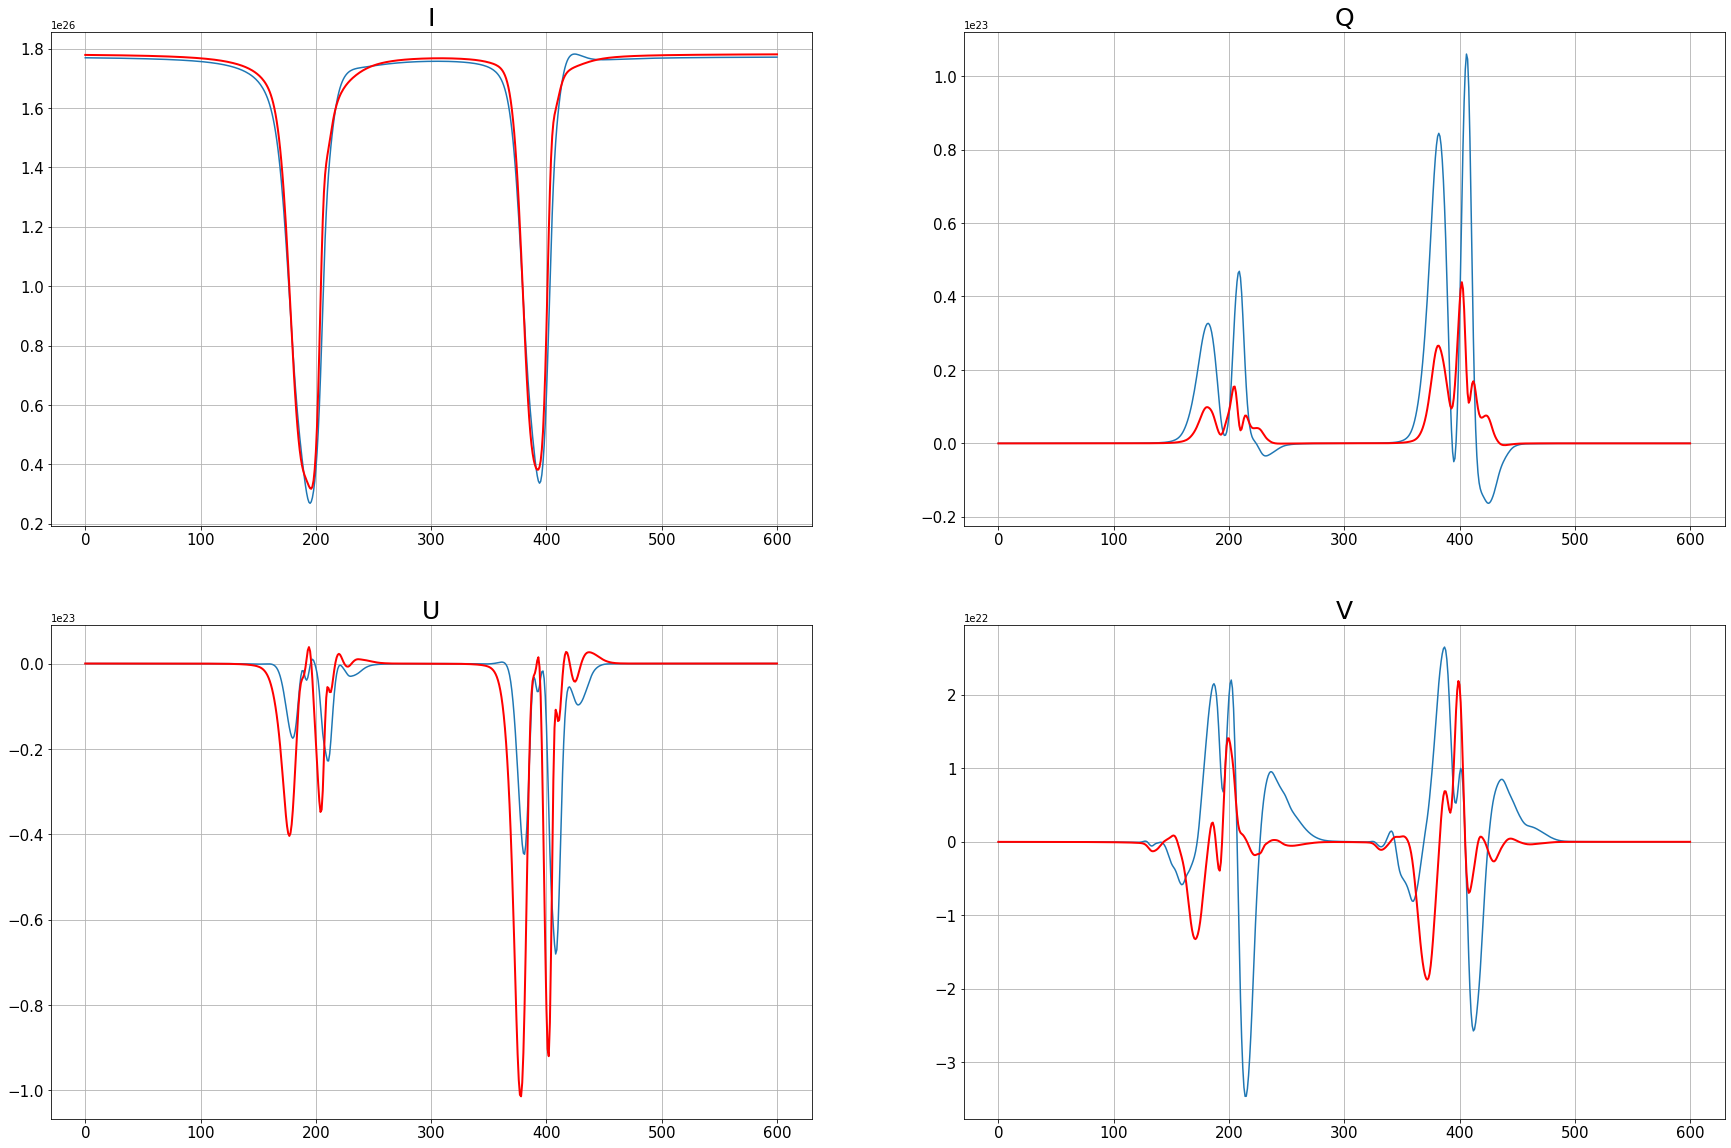


Last epoch, last batch. Index: 1040


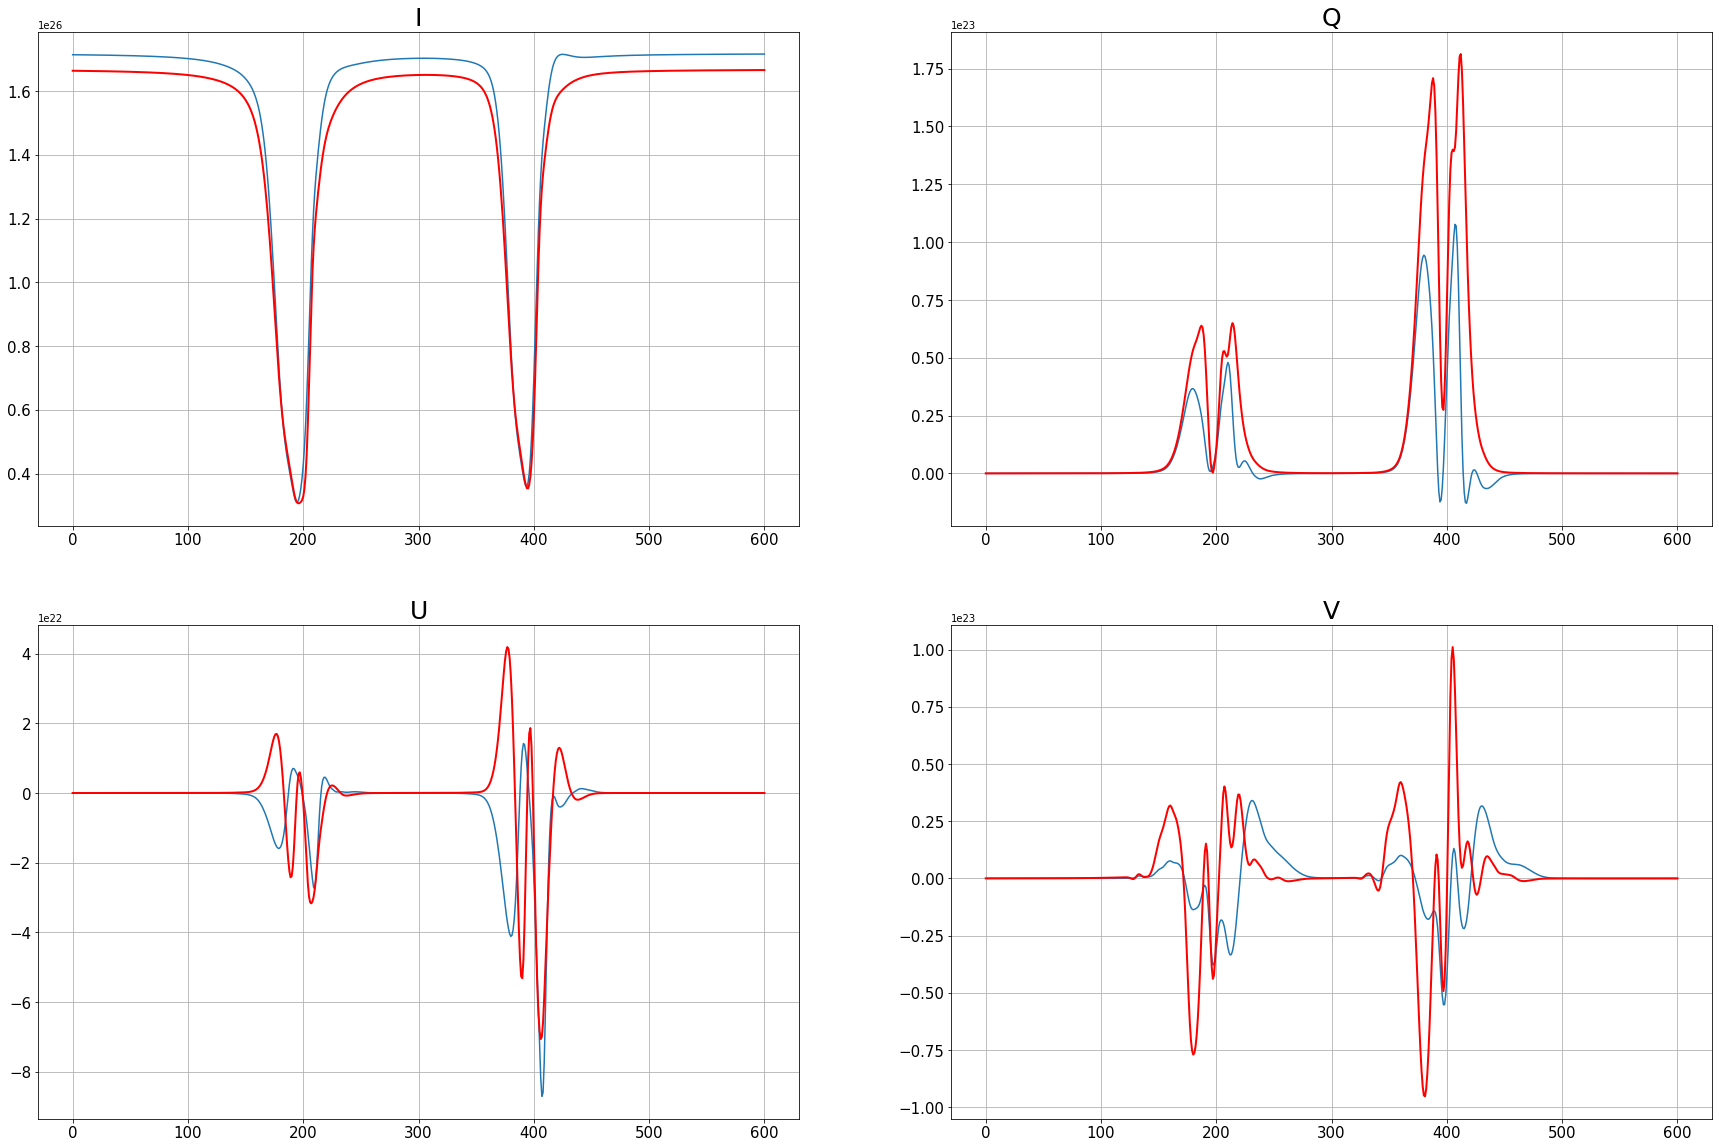


Last epoch, last batch. Index: 1219


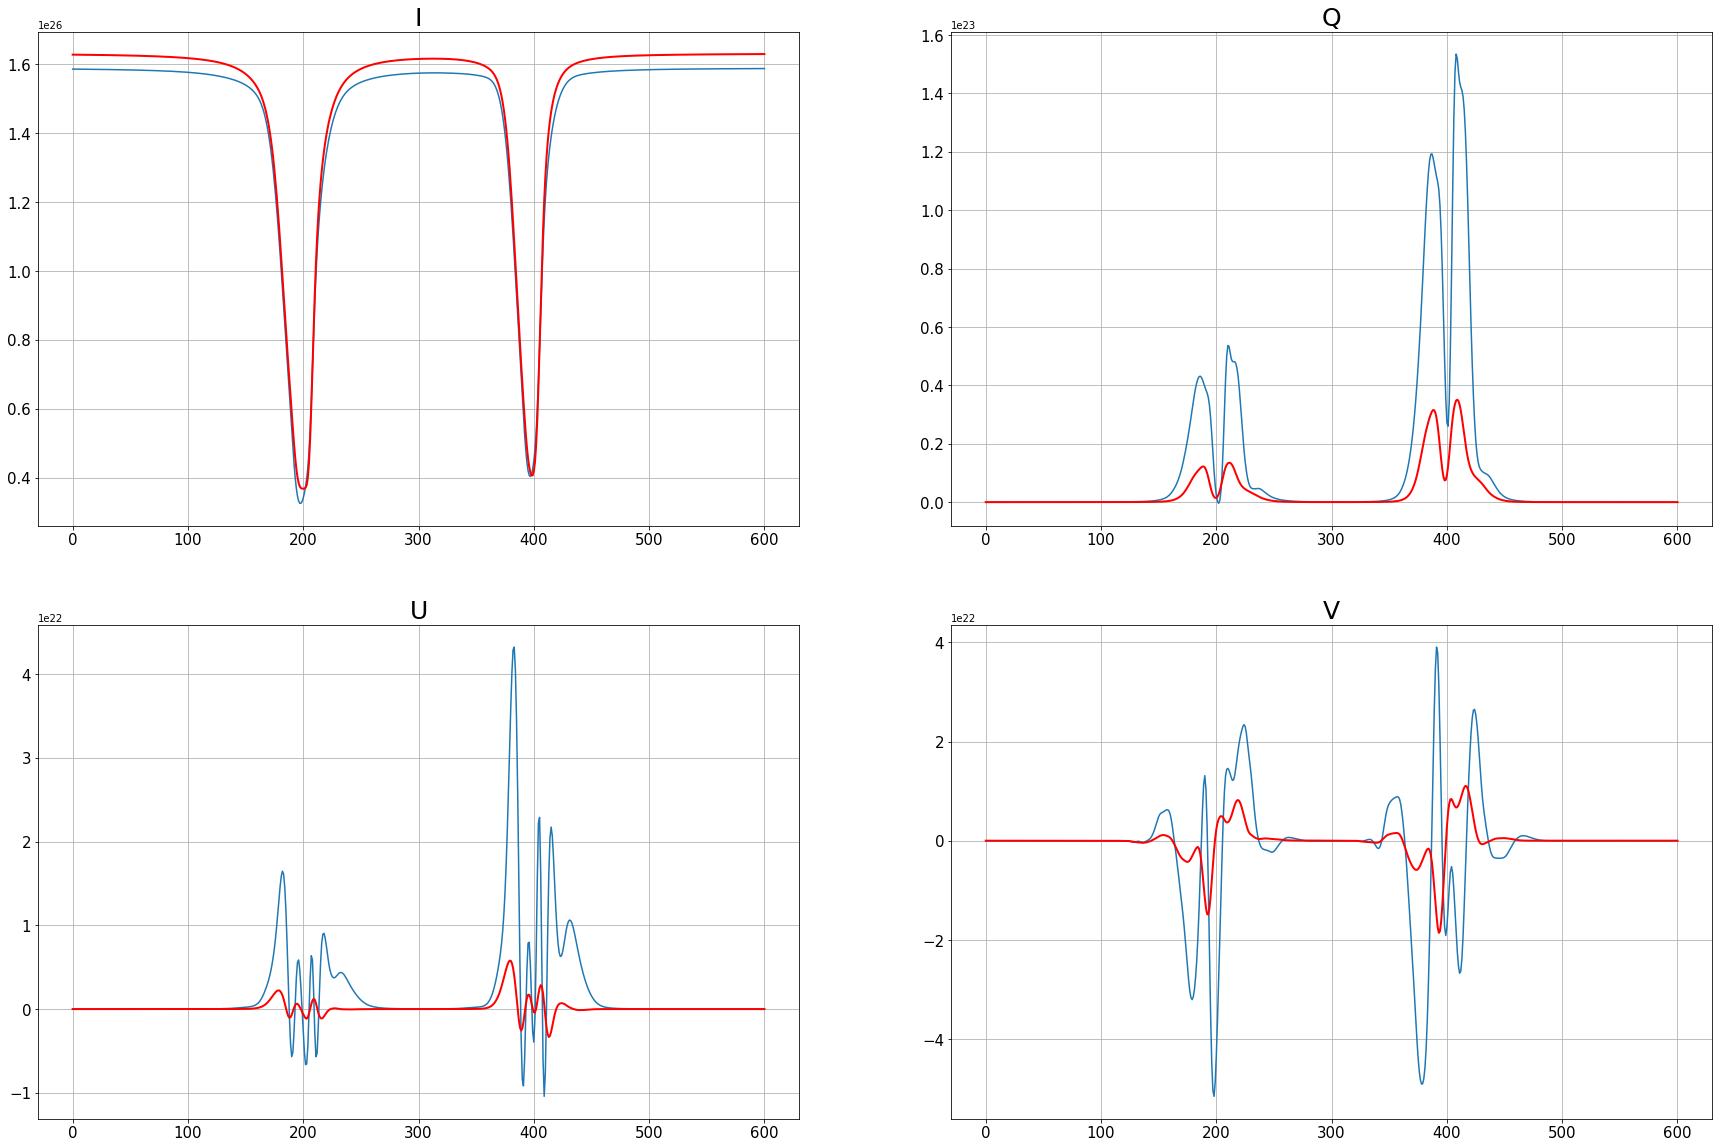


Last epoch, last batch. Index: 871


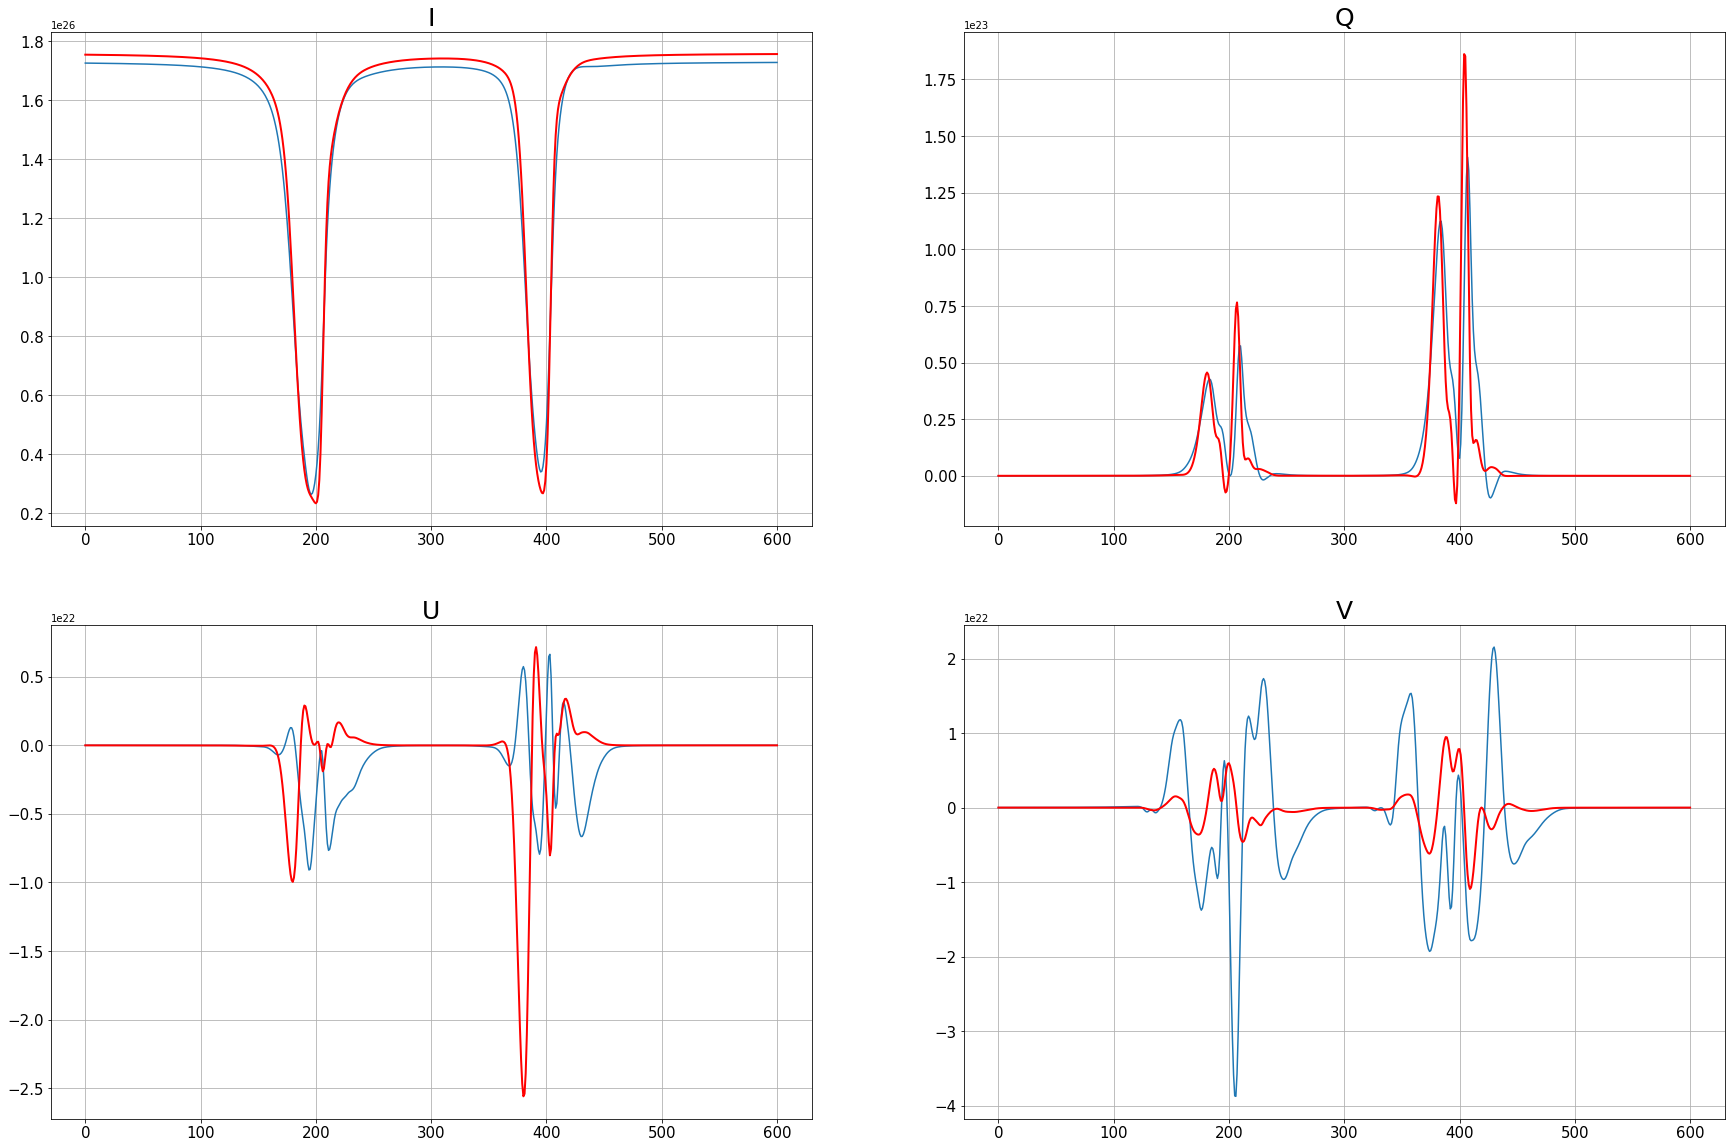


Last epoch, last batch. Index: 910


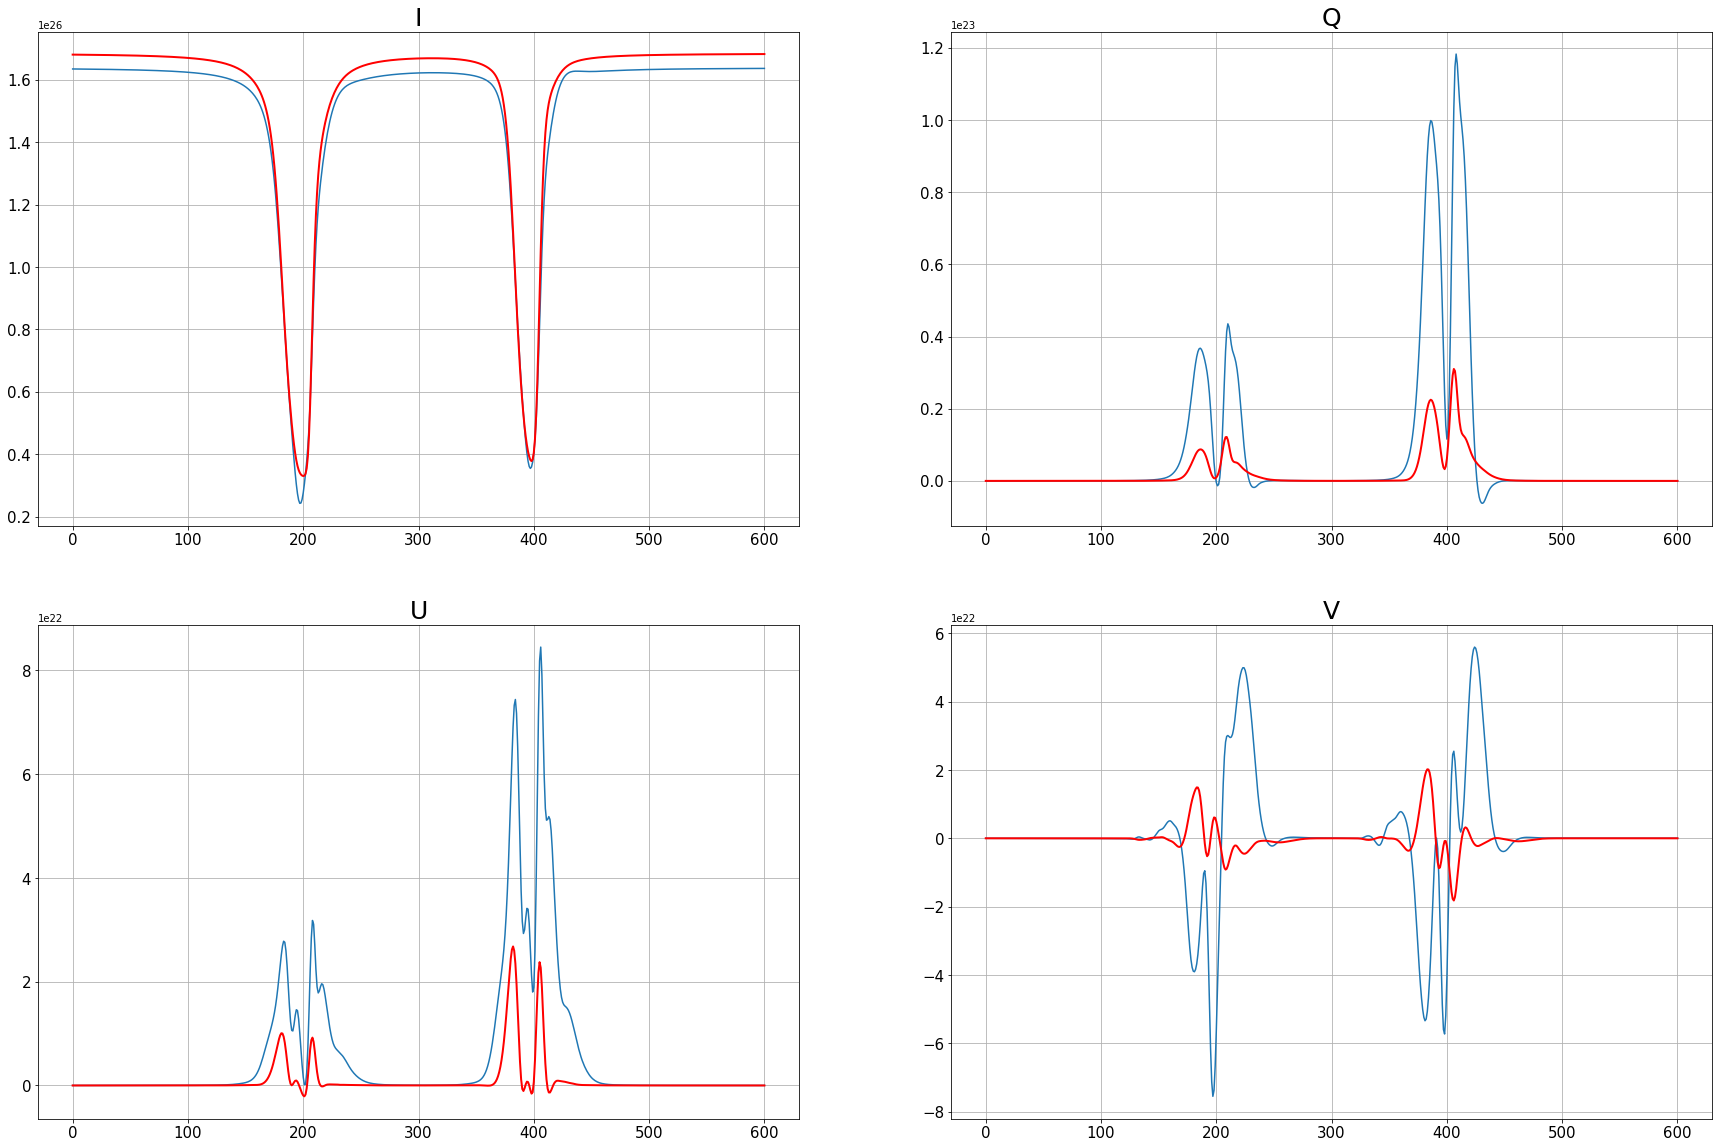


Last epoch, last batch. Index: 1113


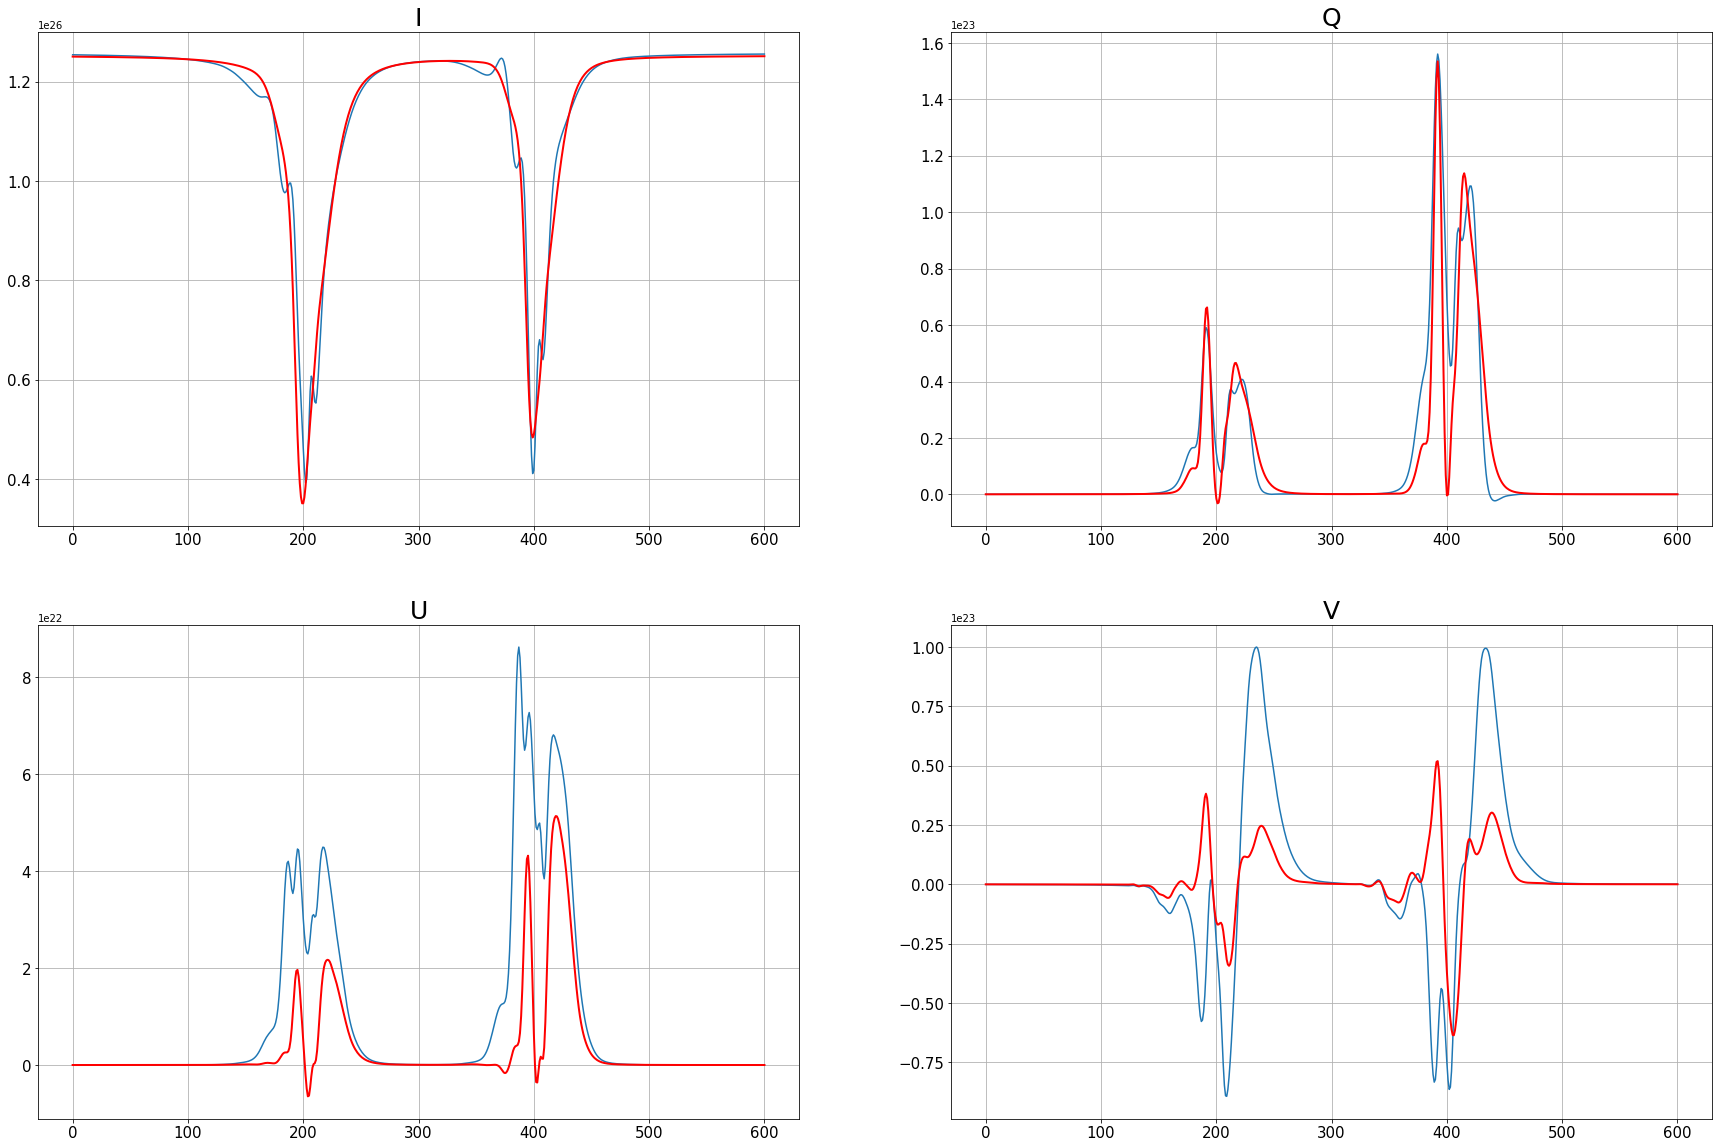


Last epoch, last batch. Index: 168


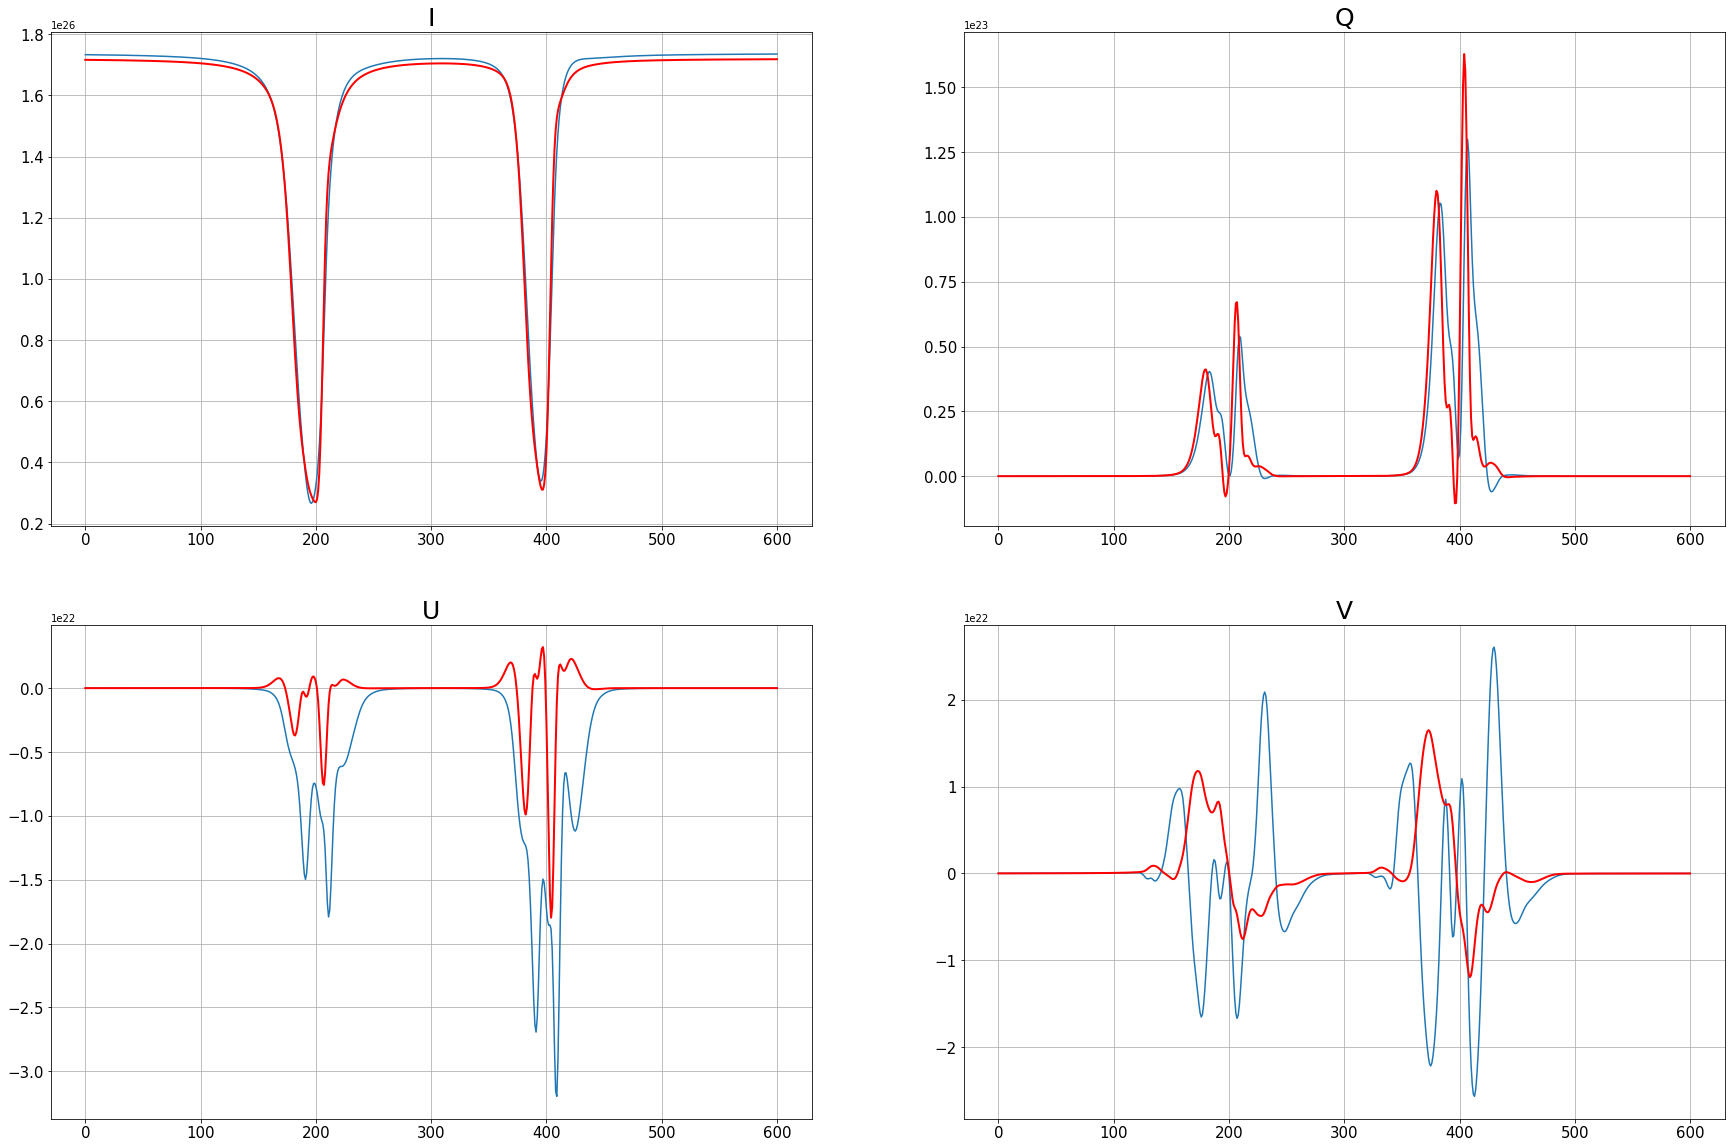


Last epoch, last batch. Index: 79


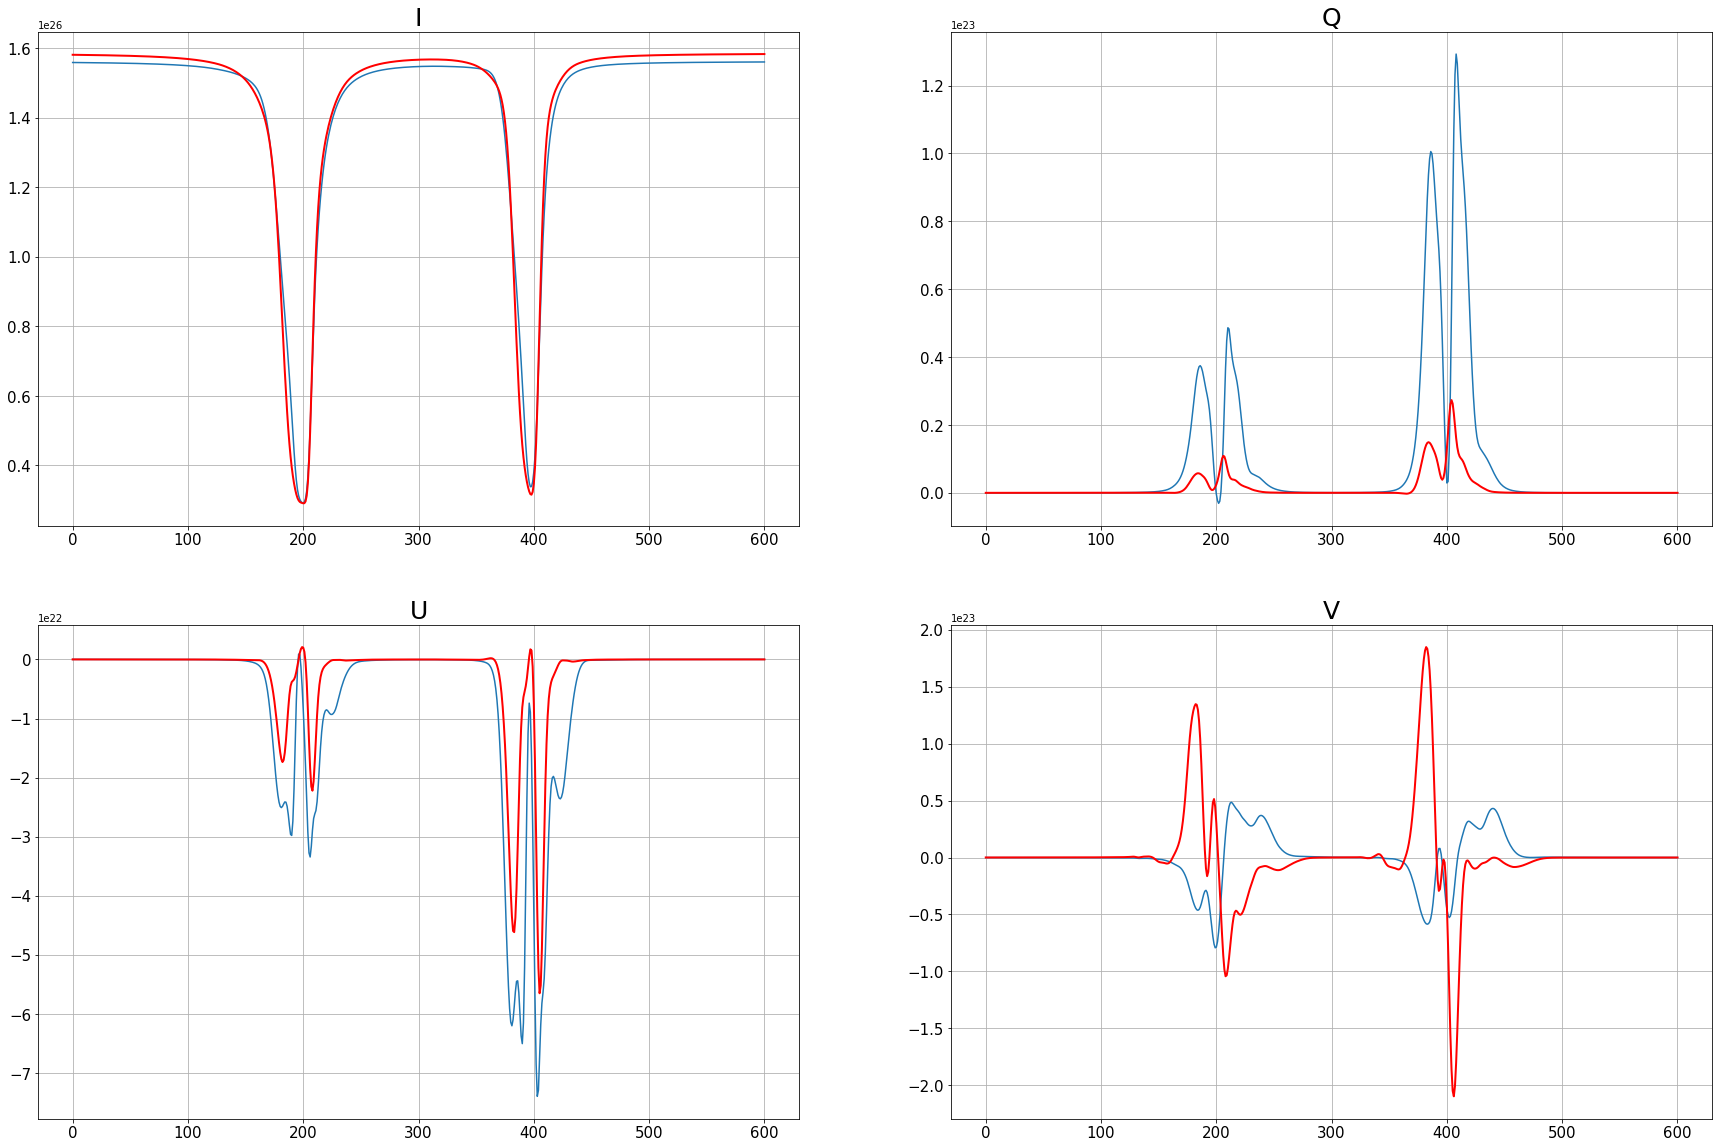

In [19]:
Map(checkpoint=False).plotting()

In [34]:
print('Epochs: {}'.format(len(torch.load('checkpoint/checkpoint_def1.pt')['validation loss'])))

Epochs: 790


### Inversion

In [9]:
class inversion():
    
    def __init__(self, n_iter, num_workers=0, path='checkpoint/checkpoint_def1.pt', lr=1e-3, gpu=0):
        
        # Iterations
        self.n_iter = n_iter
        
        # Check if a GPU is available
        self.cuda = torch.cuda.is_available()
        self.gpu = gpu        

        # In case there is, select it. Otherwise, default to CPU
        self.device = torch.device(f"cuda:{self.gpu}" if self.cuda else "cpu")
        
        # Use  num_workers to provide data to the GPU
        self.kwargs = {'num_workers': num_workers, 'pin_memory': False} if self.cuda else {}
        
        # Dataset
        self.dataset = Data()
        
        
        # Choose a random index from the validation set (last 20% of the dataset)
        #idx = np.arange(self.dataset.n_training)
        #self.validation_index = idx[int((1-0.2)*self.dataset.n_training):]
        
        #self.rand_idx = np.random.random_integers(self.validation_index[0], 
        #                                          self.validation_index[-1]+1, 1)
        
        # I chose a particular index so it remains constant and comparison between different trainings can be done
        self.rand_idx=67000
        self.observ_i = self.dataset.conv_stokes[:, self.rand_idx, :][:,None,:]
        self.observ_i = self.dataset.PCA(self.observ_i)[-1][:, :, 0:self.dataset.npca_s] / self.dataset.multiplier_cs[:,None,None]
        self.observ_i = torch.tensor(self.observ_i.flatten().astype('float32'), device=self.device)
        
        
        self.n_mags, self.n1_m, self.n2_m = self.dataset.mags.shape
        self.n_stokes, self.n1_s, self.n_lambda = self.dataset.conv_stokes.shape
        
        inputSize = self.n_mags * self.dataset.npca_m
        outputSize = self.n_stokes * self.dataset.npca_s
        self.net = Net(inputSize, outputSize).to(self.device)
        
        self.net.load_state_dict(torch.load(path)['state_dict'])
        self.net.eval()

        for param in self.net.parameters():
            param.requires_grad = False

        self.input = torch.zeros(inputSize, requires_grad=True, device=self.device)
        
        self.optimizer = optim.Adam([self.input], lr=lr)
        self.criterion = nn.MSELoss()
        
    def recon_x(self, x, n, n2, npca, mult, V):
        recon = torch.zeros((n, 1, n2))
        for i in torch.arange(n):
            recon[i,:,:]= torch.einsum('ij, jk -> ik', 
                                       x[i, :, 0:npca] * torch.tensor(mult[i].astype('float32')), 
                                       torch.tensor(V[i,0:npca, :].astype('float32')) )
        return recon.reshape((n,n2))
        
        
    def optimize(self):
        self.loss_iter = []
        self.out_iter = []
        self.input_iter = []
        
        for i in range(self.n_iter):
            self.optimizer.zero_grad()
            
            out = self.net(self.input)
            loss = self.criterion(out, self.observ_i)
            loss.backward()
            
            self.optimizer.step()
            
            temp = self.input
            self.loss_iter.append(loss.item())
            self.out_iter.append(out.detach().cpu())
            self.input_iter.append(temp.detach().cpu())
        print(self.loss_iter[-1])
        self.plot()
    
    def plot(self):
        
        plt.rcParams.update({'axes.labelsize':25, 'axes.labelweight':'bold', 'axes.labelpad':20,
                    'axes.titlesize':30, 'axes.titleweight':'bold', 'axes.titlepad':20, 'legend.markerscale':3,
                    'xtick.labelsize':25, 'ytick.labelsize':25,
                    'legend.fontsize':20})
        
        iter_idx = [int(2*(self.n_iter/4))-1, int(3*(self.n_iter/4))-1, self.n_iter-1]
        #np.linspace(0, self.n_iter-1, 3, dtype='int')
        
        _ = plt.figure(figsize=(25,12))
        plt.subplot(121)
        plt.plot(np.arange(self.n_iter), self.loss_iter)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(122)
        plt.plot(np.arange(100)+49900, self.loss_iter[-100:])
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        
        _ = plt.figure(figsize=(25,30))
        for g in iter_idx:
            input_iter = self.input_iter[g].reshape((self.n_mags, 1, self.dataset.npca_m))
            recon_input = self.recon_x(input_iter, self.n_mags, self.n2_m, self.dataset.npca_m, 
                                     self.dataset.multiplier_cm, self.dataset.V_m )
            
            for m, magnitude in enumerate(['Tempertature', 'Total Pressure', 'Magentic field', \
                                 'Los Velocity', 'Magentic field inclination', 'Magnetic field azimuth']):
                plt.subplot(3,2,m+1)
                plt.title(magnitude)
                
                if g==iter_idx[0]:
                    plt.plot(np.arange(self.n2_m), np.squeeze(self.dataset.mags[m, self.rand_idx, :]), 'r-',\
                            label='target')
                    
                plt.plot(np.arange(self.n2_m), recon_input[m,:], label= 'iter {}'.format(g+1))
                plt.legend()
        
        plt.tight_layout(h_pad=10)
        plt.show()
        
        
        _ = plt.figure(figsize=(25,30))
        for g in iter_idx:
            out_iter = self.out_iter[g].reshape((self.n_stokes, 1, self.dataset.npca_s))
            recon_out = self.recon_x(out_iter, self.n_stokes, self.n_lambda, self.dataset.npca_s, 
                                     self.dataset.multiplier_cs, self.dataset.V_s )
            
            for s, stokes_param in enumerate(['Intensity','Q','U','V']):
                plt.subplot(4,1,s+1)
                plt.title(stokes_param)
                if g==iter_idx[0]:
                    plt.plot(np.arange(self.n_lambda), np.squeeze(self.dataset.conv_stokes[s, self.rand_idx, :]), \
                             'r-',label='target')
                plt.plot(np.arange(self.n_lambda), recon_out[s,:], label= 'iter {}'.format(g+1))
                plt.legend()
        
        plt.tight_layout(h_pad=10)
        plt.show()


8.352416443813127e-06


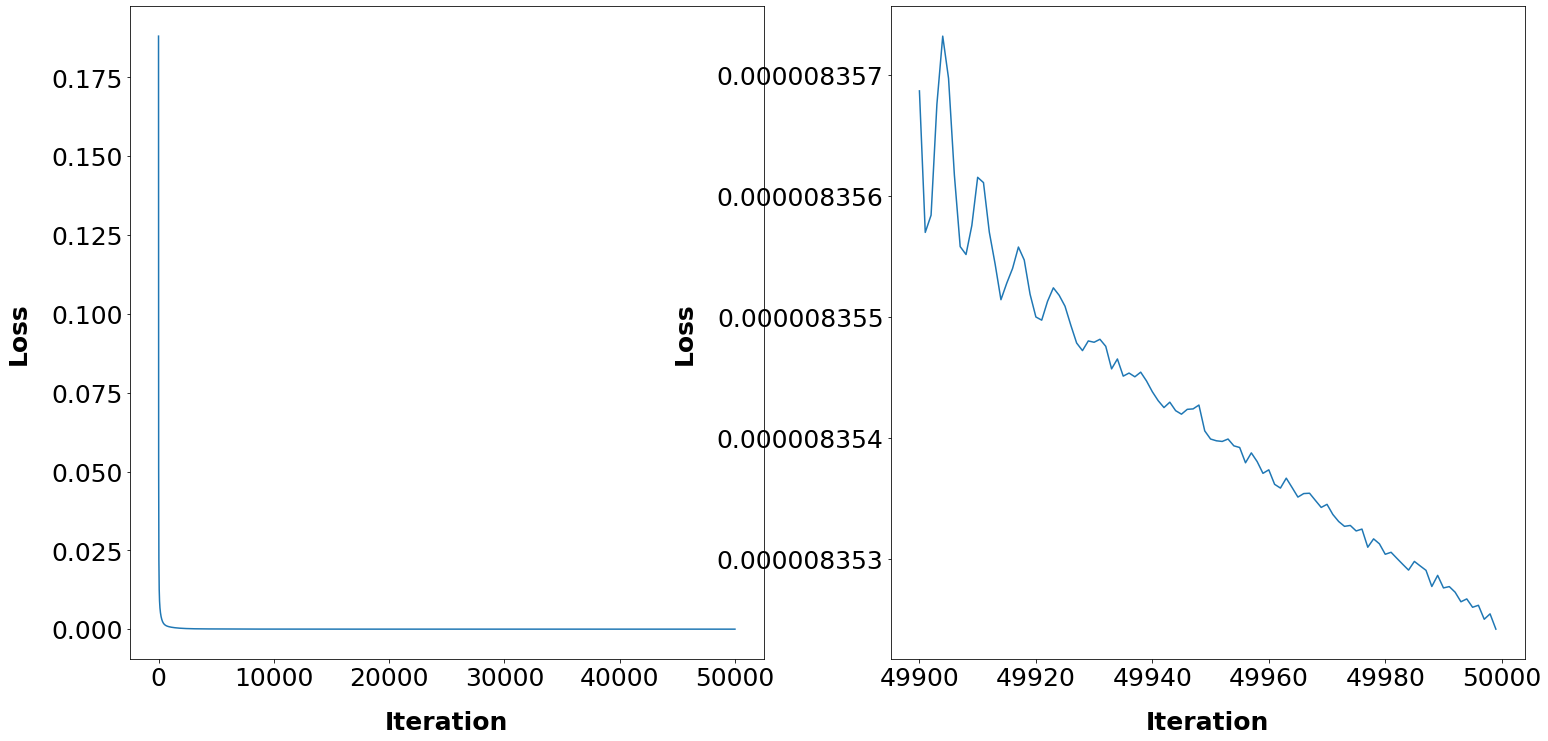

C:\Users\Yazmina\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


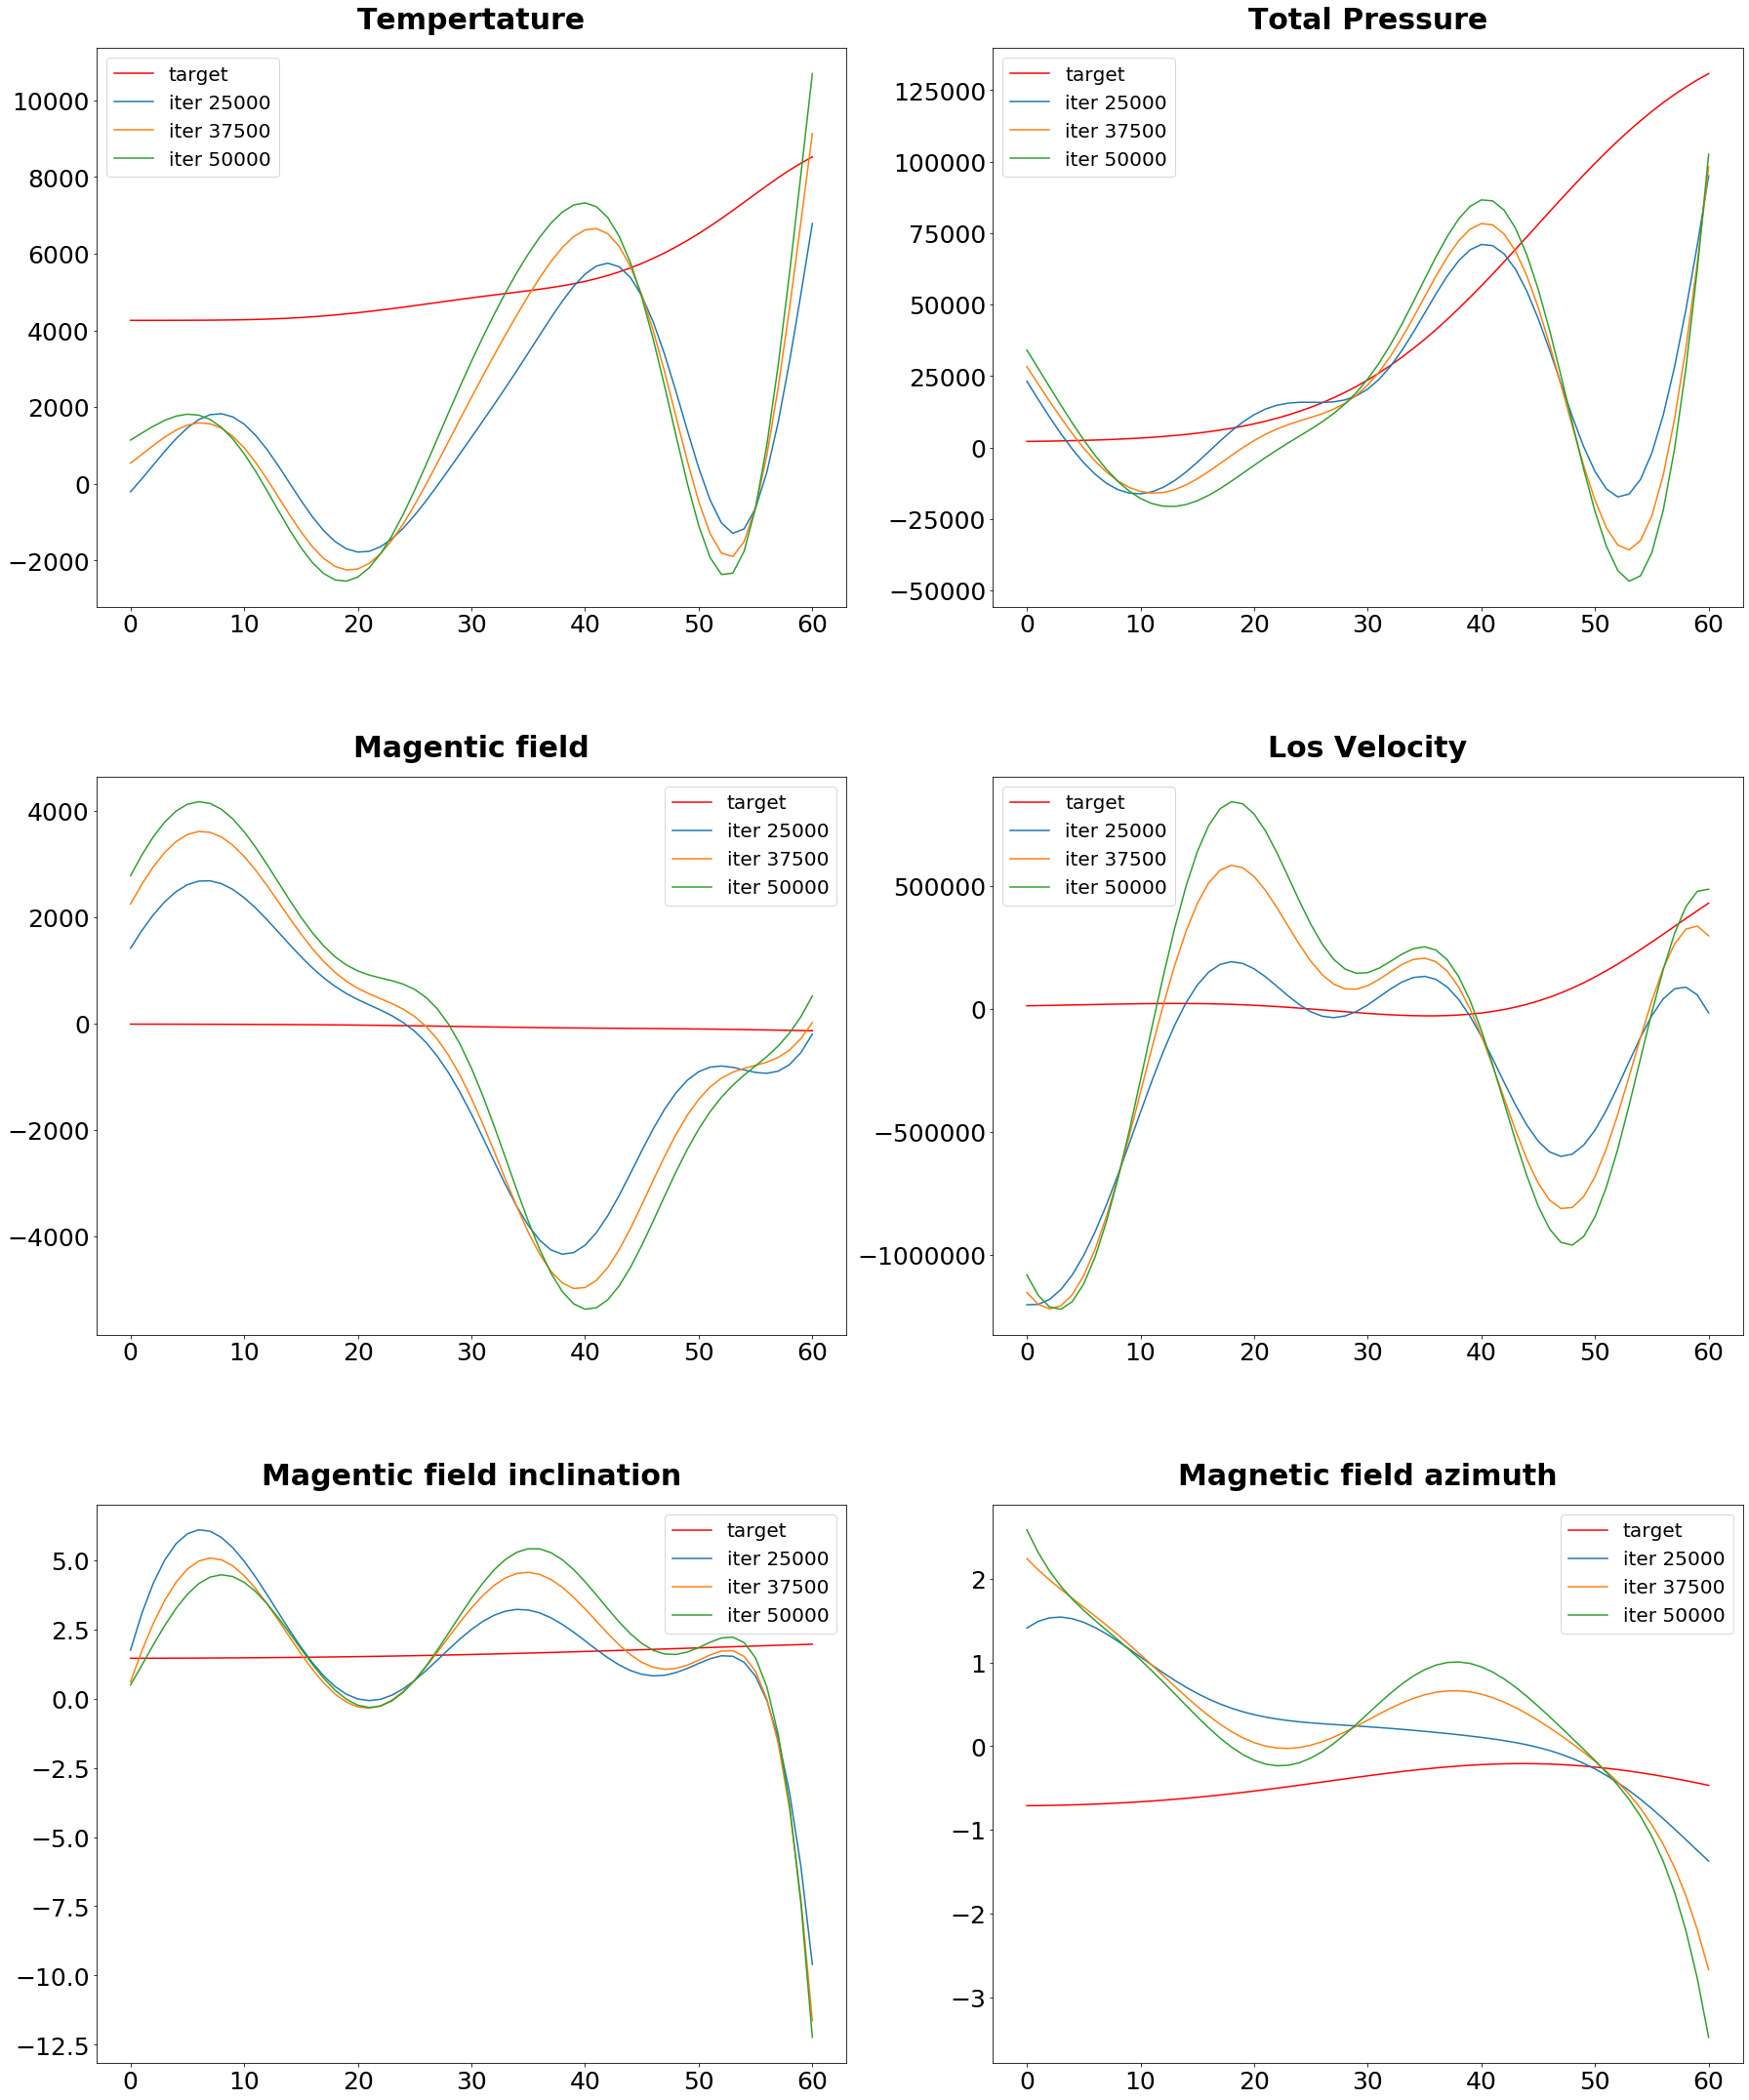

C:\Users\Yazmina\Anaconda3\lib\site-packages\ipykernel_launcher.py:135: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


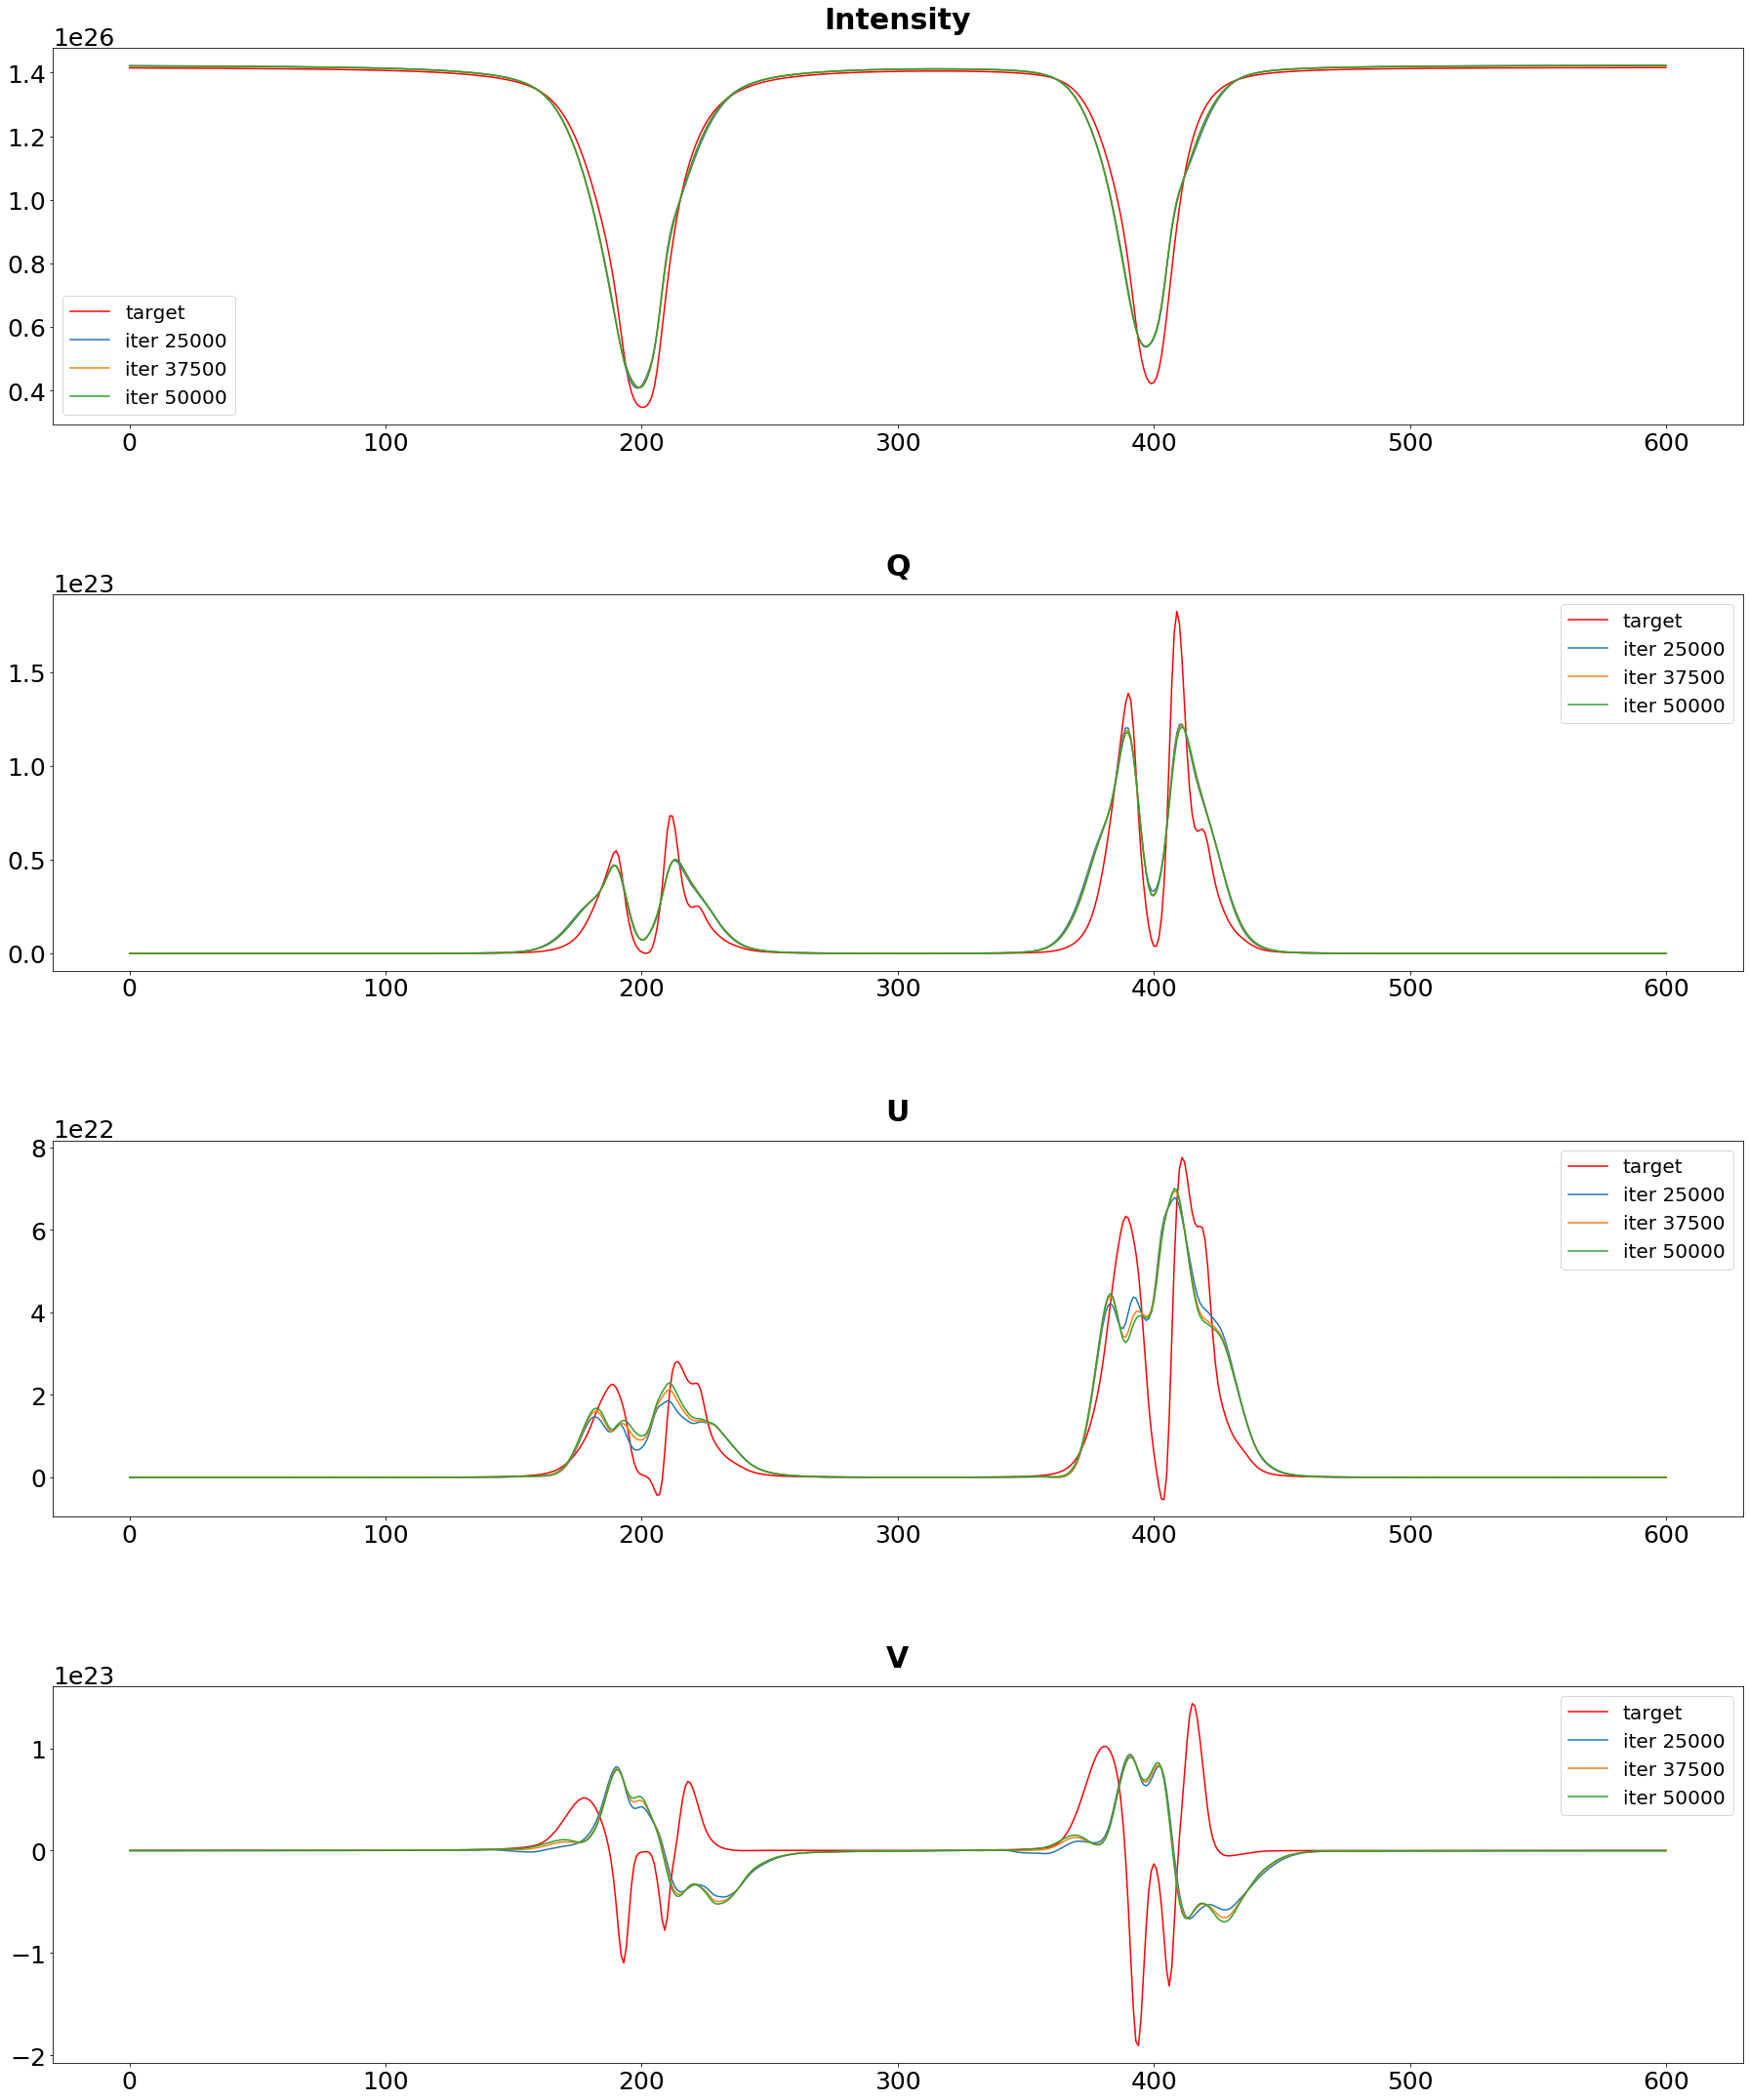

In [10]:
inversion(n_iter=50000).optimize()